# Differential gene expression

In this tutorial we will cover about Differetial gene expression, which comprises an extensive range of topics and methods. In single cell, differential expresison can have multiple functionalities such as of identifying marker genes for cell populations, as well as differentially regulated genes across conditions (healthy vs control). We will also exercise on how to account the batch information in your test.


Differential expression is performed with the function `rank_genes_group`.  The default method to compute differential expression is the `t-test_overestim_var`. Other implemented methods are: `logreg`, `t-test` and `wilcoxon`.

By default, the .raw attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. 

The clustering with resolution 0.6 seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

First, let's import libraries and fetch the clustered data from the previous lab.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5594, 3067)
(5594, 18752)
  (0, 1)	1.0
  (0, 6)	1.0
  (1, 6)	2.0
  (2, 6)	1.0


As you can see, the X matrix only contains the variable genes, while the raw matrix contains all genes.

Printing a few of the values in `adata.raw.X` shows that the raw matrix is not normalized.

For DGE analysis we would like to run with all genes, but on normalized values, so we will have to revert back to the raw matrix and renormalize.

In [5]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Now lets look at the clustering of the object we loaded in the umap. We will use `louvain_0.6` clustering in this exercise.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


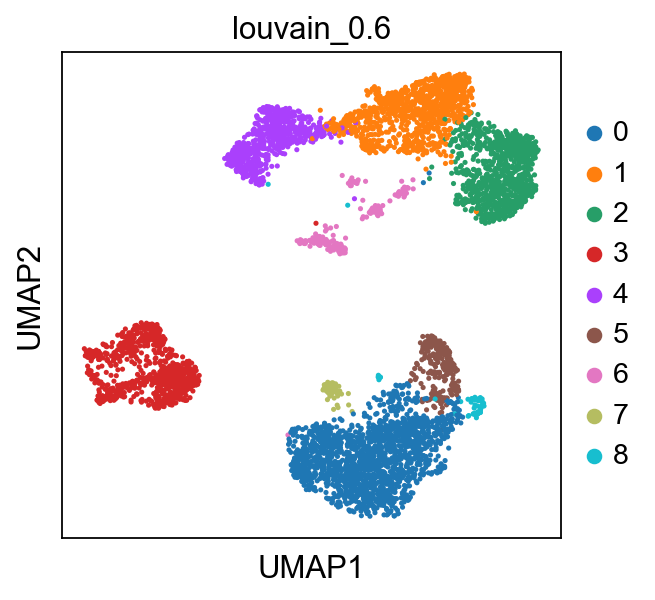

In [6]:
sc.pl.umap(adata, color='louvain_0.6')


### T-test 

ranking genes
    finished (0:00:00)


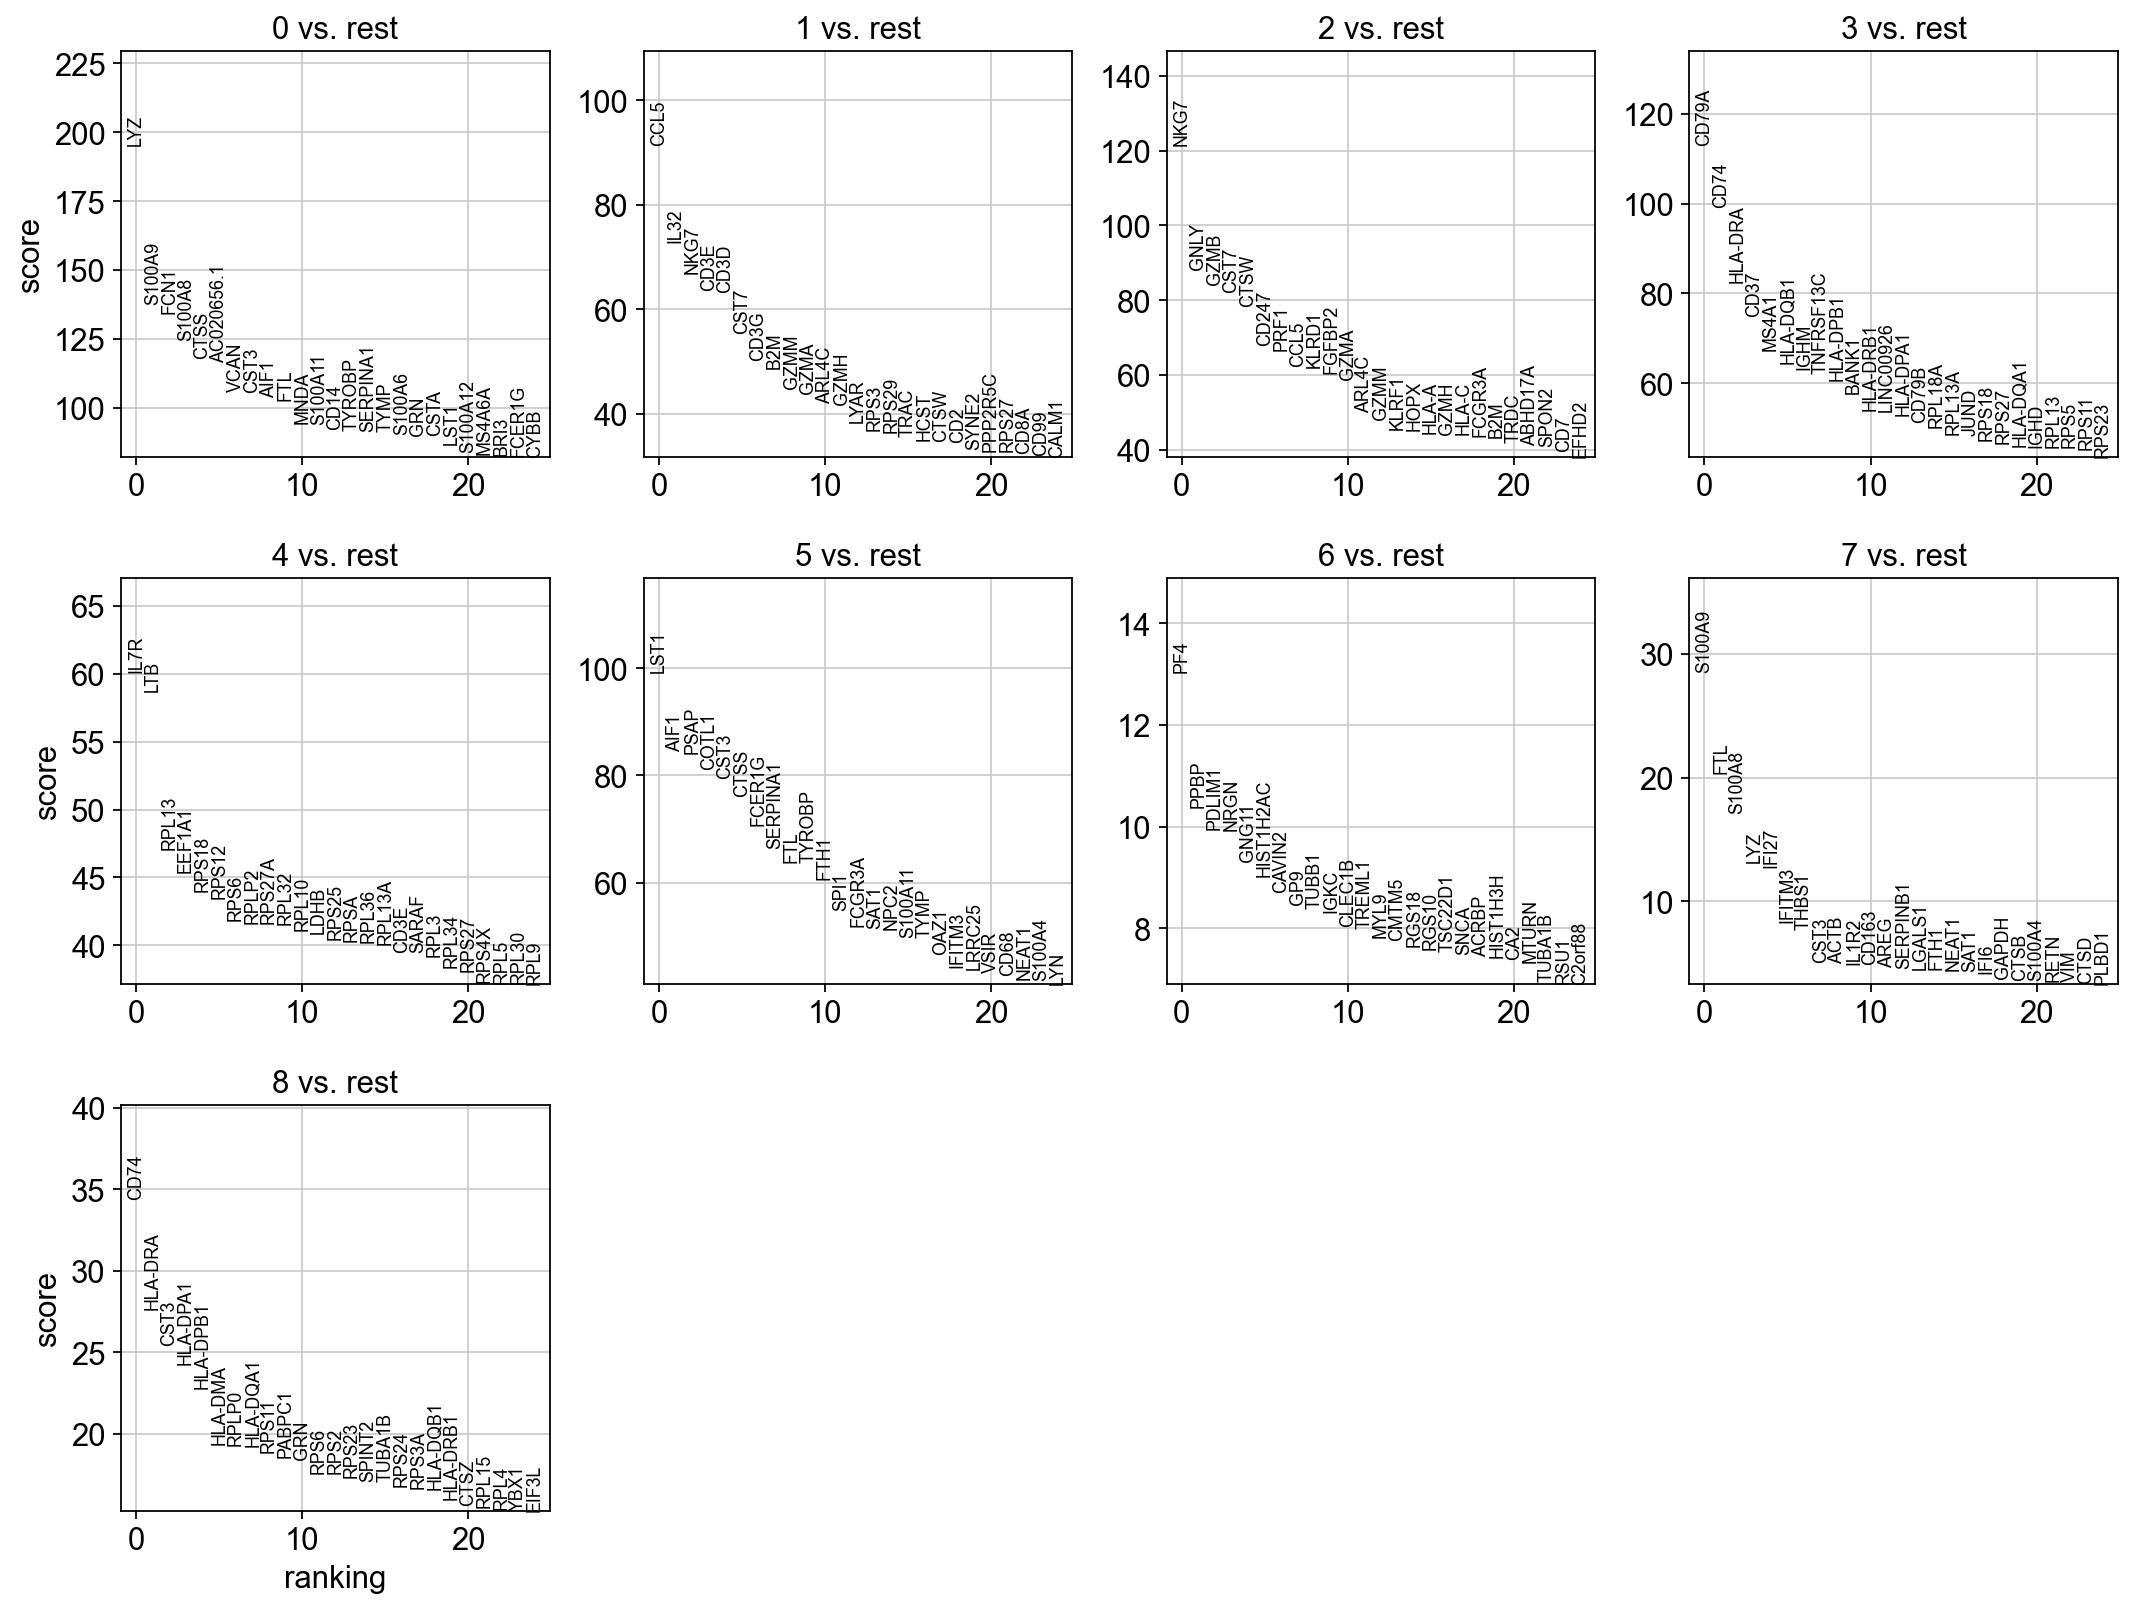

In [7]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")


In [8]:
# results are stored in the adata.uns["t-test"] slot
adata

AnnData object with n_obs × n_vars = 5594 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'dendrogram_leiden_0.6', 'dendrogram_louvain_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors', 'leiden', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_1.0_colors', 'leiden_1.4_color

### T-test overestimated_variance

ranking genes
    finished (0:00:00)


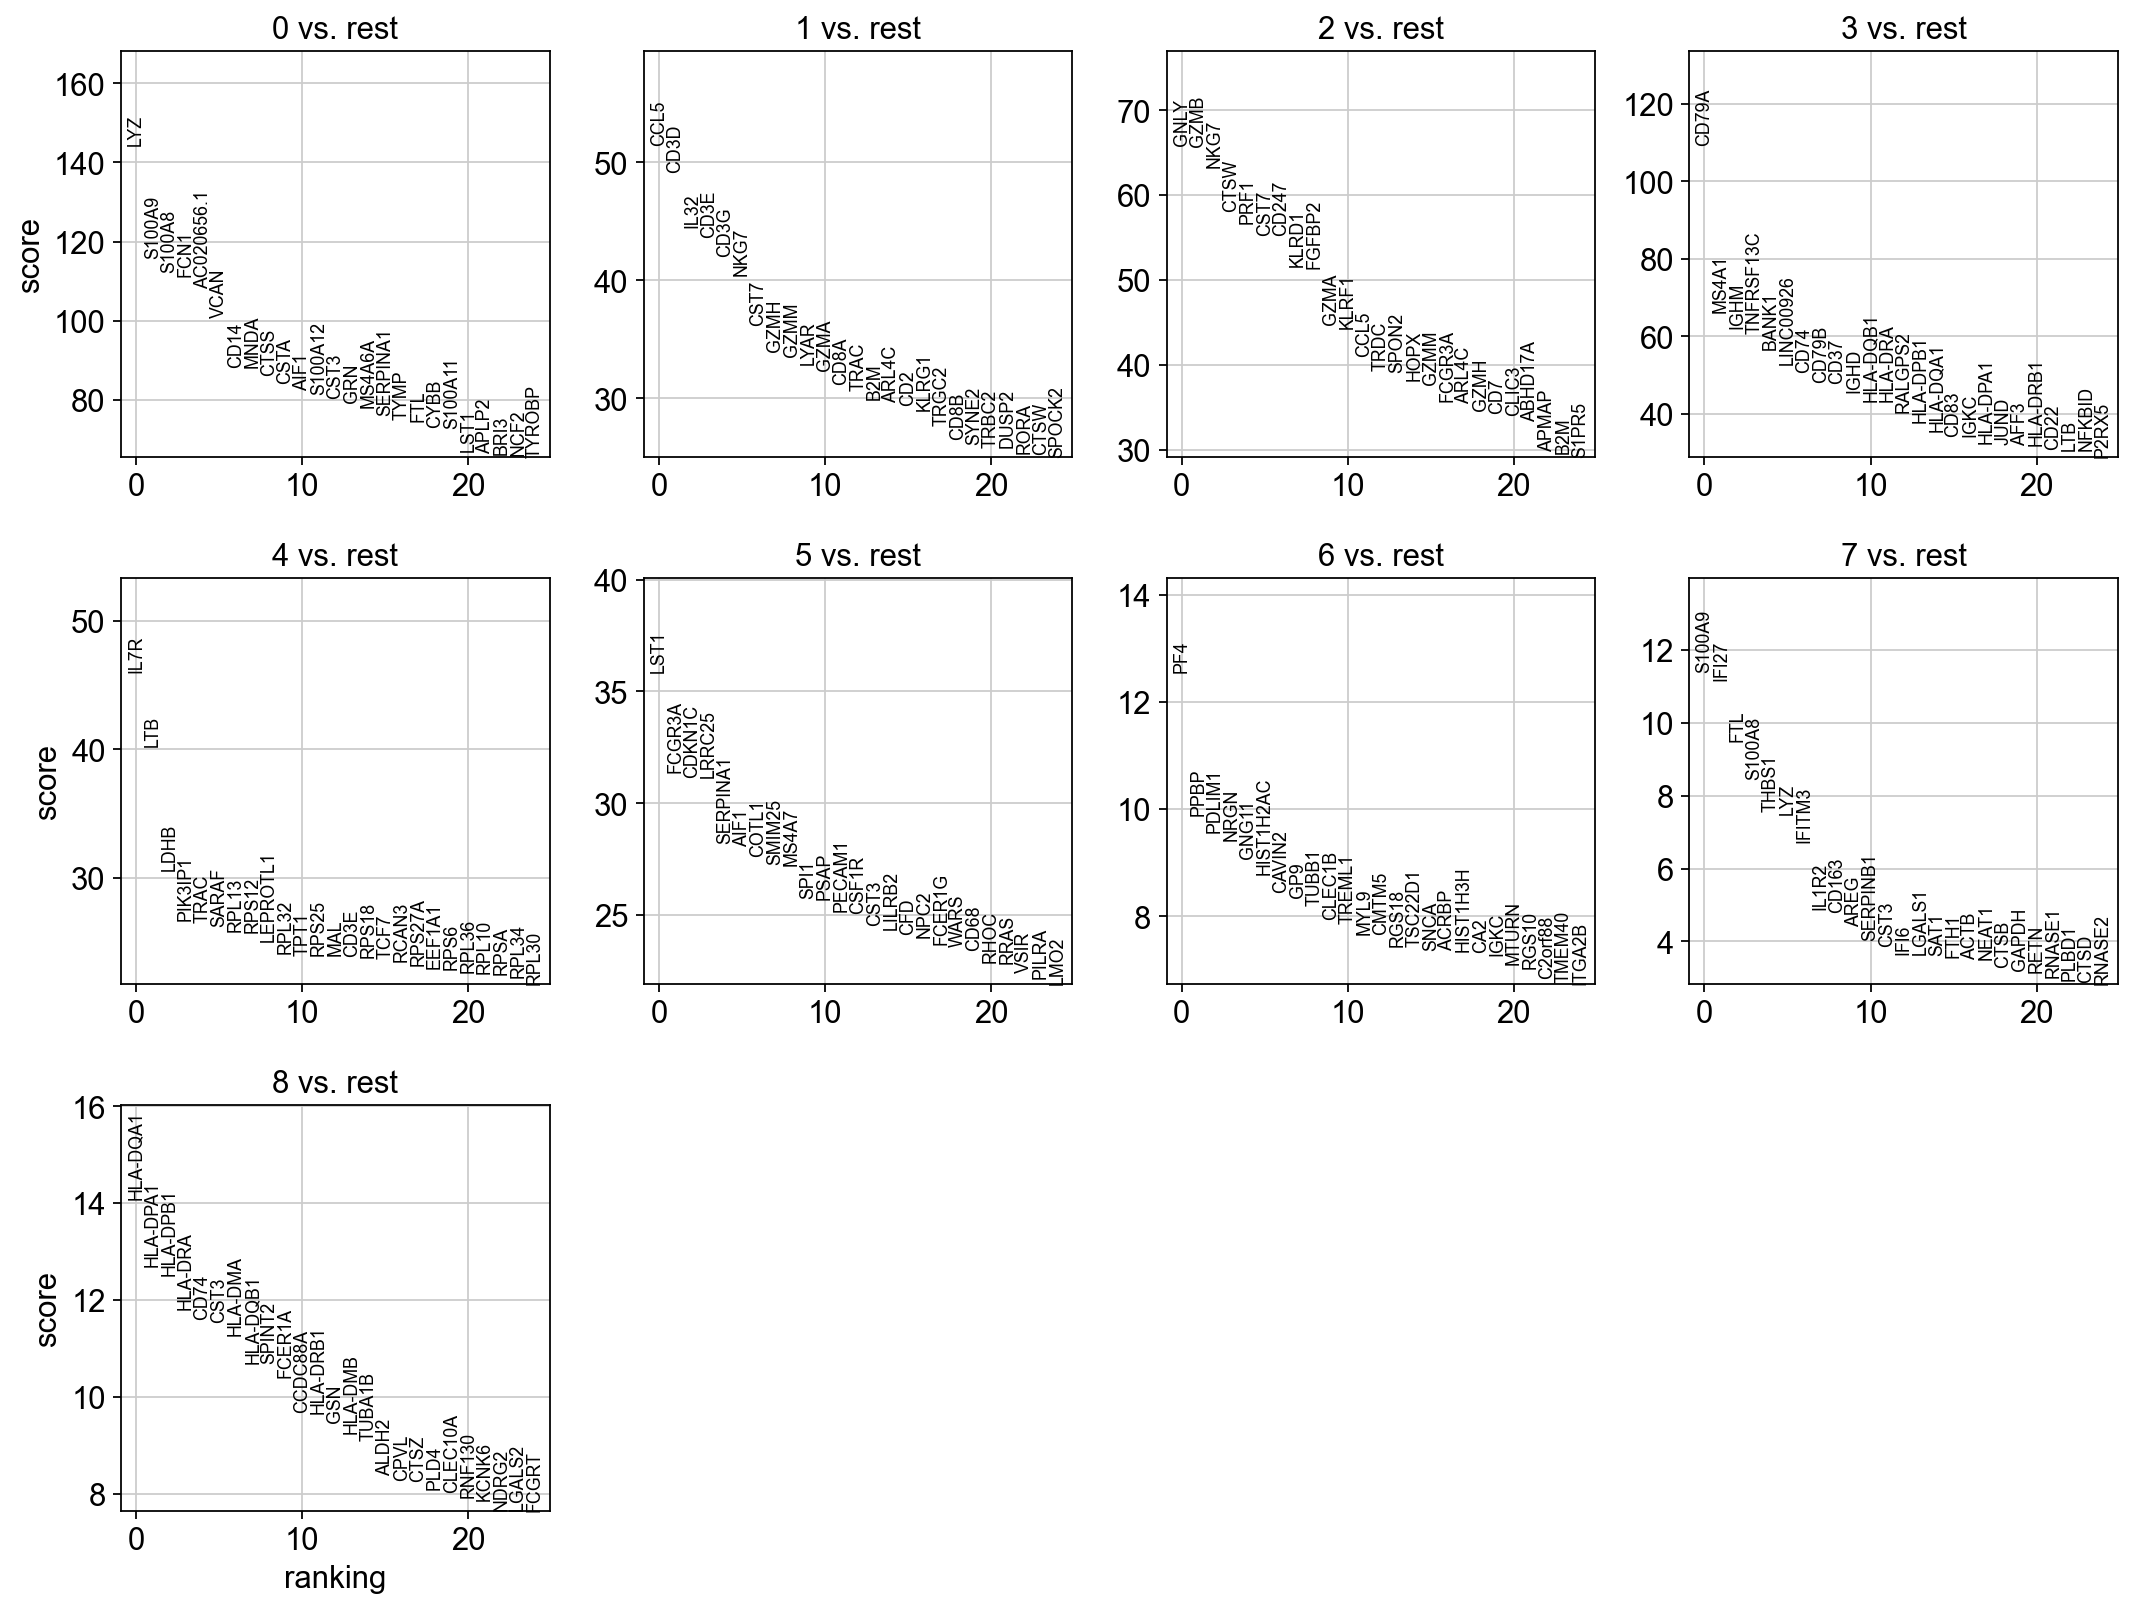

In [9]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")


### Wilcoxon rank-sum

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:05)


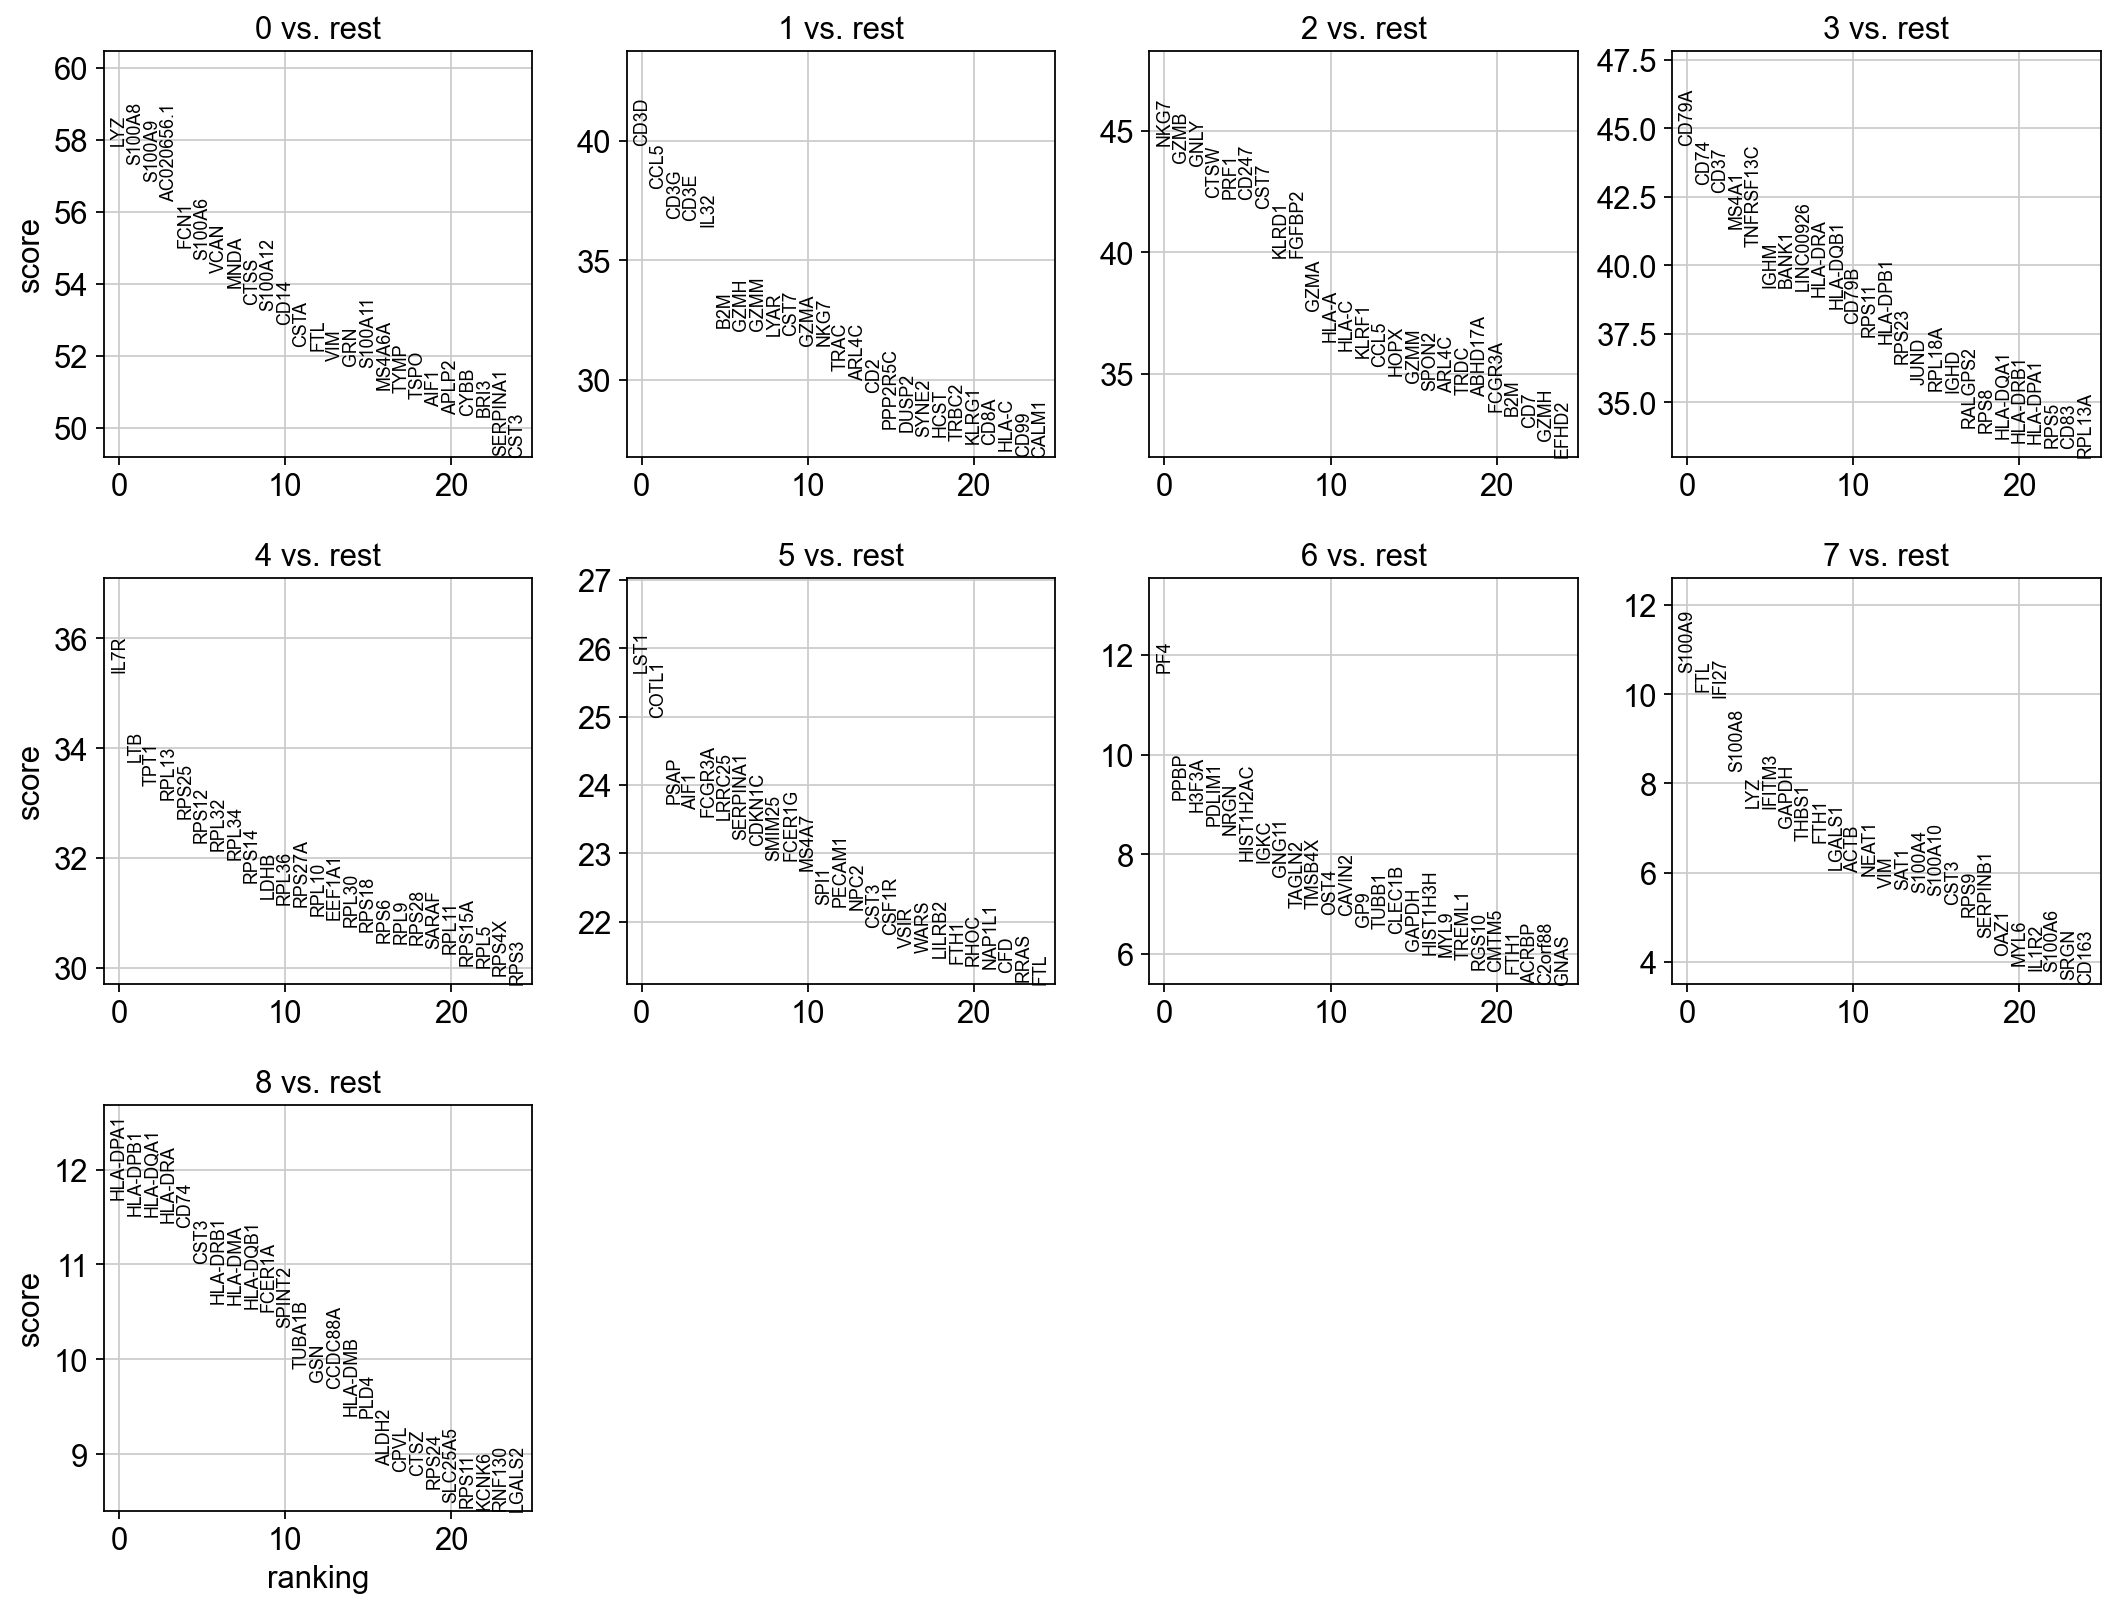

In [10]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### Logistic regression test

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:15)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


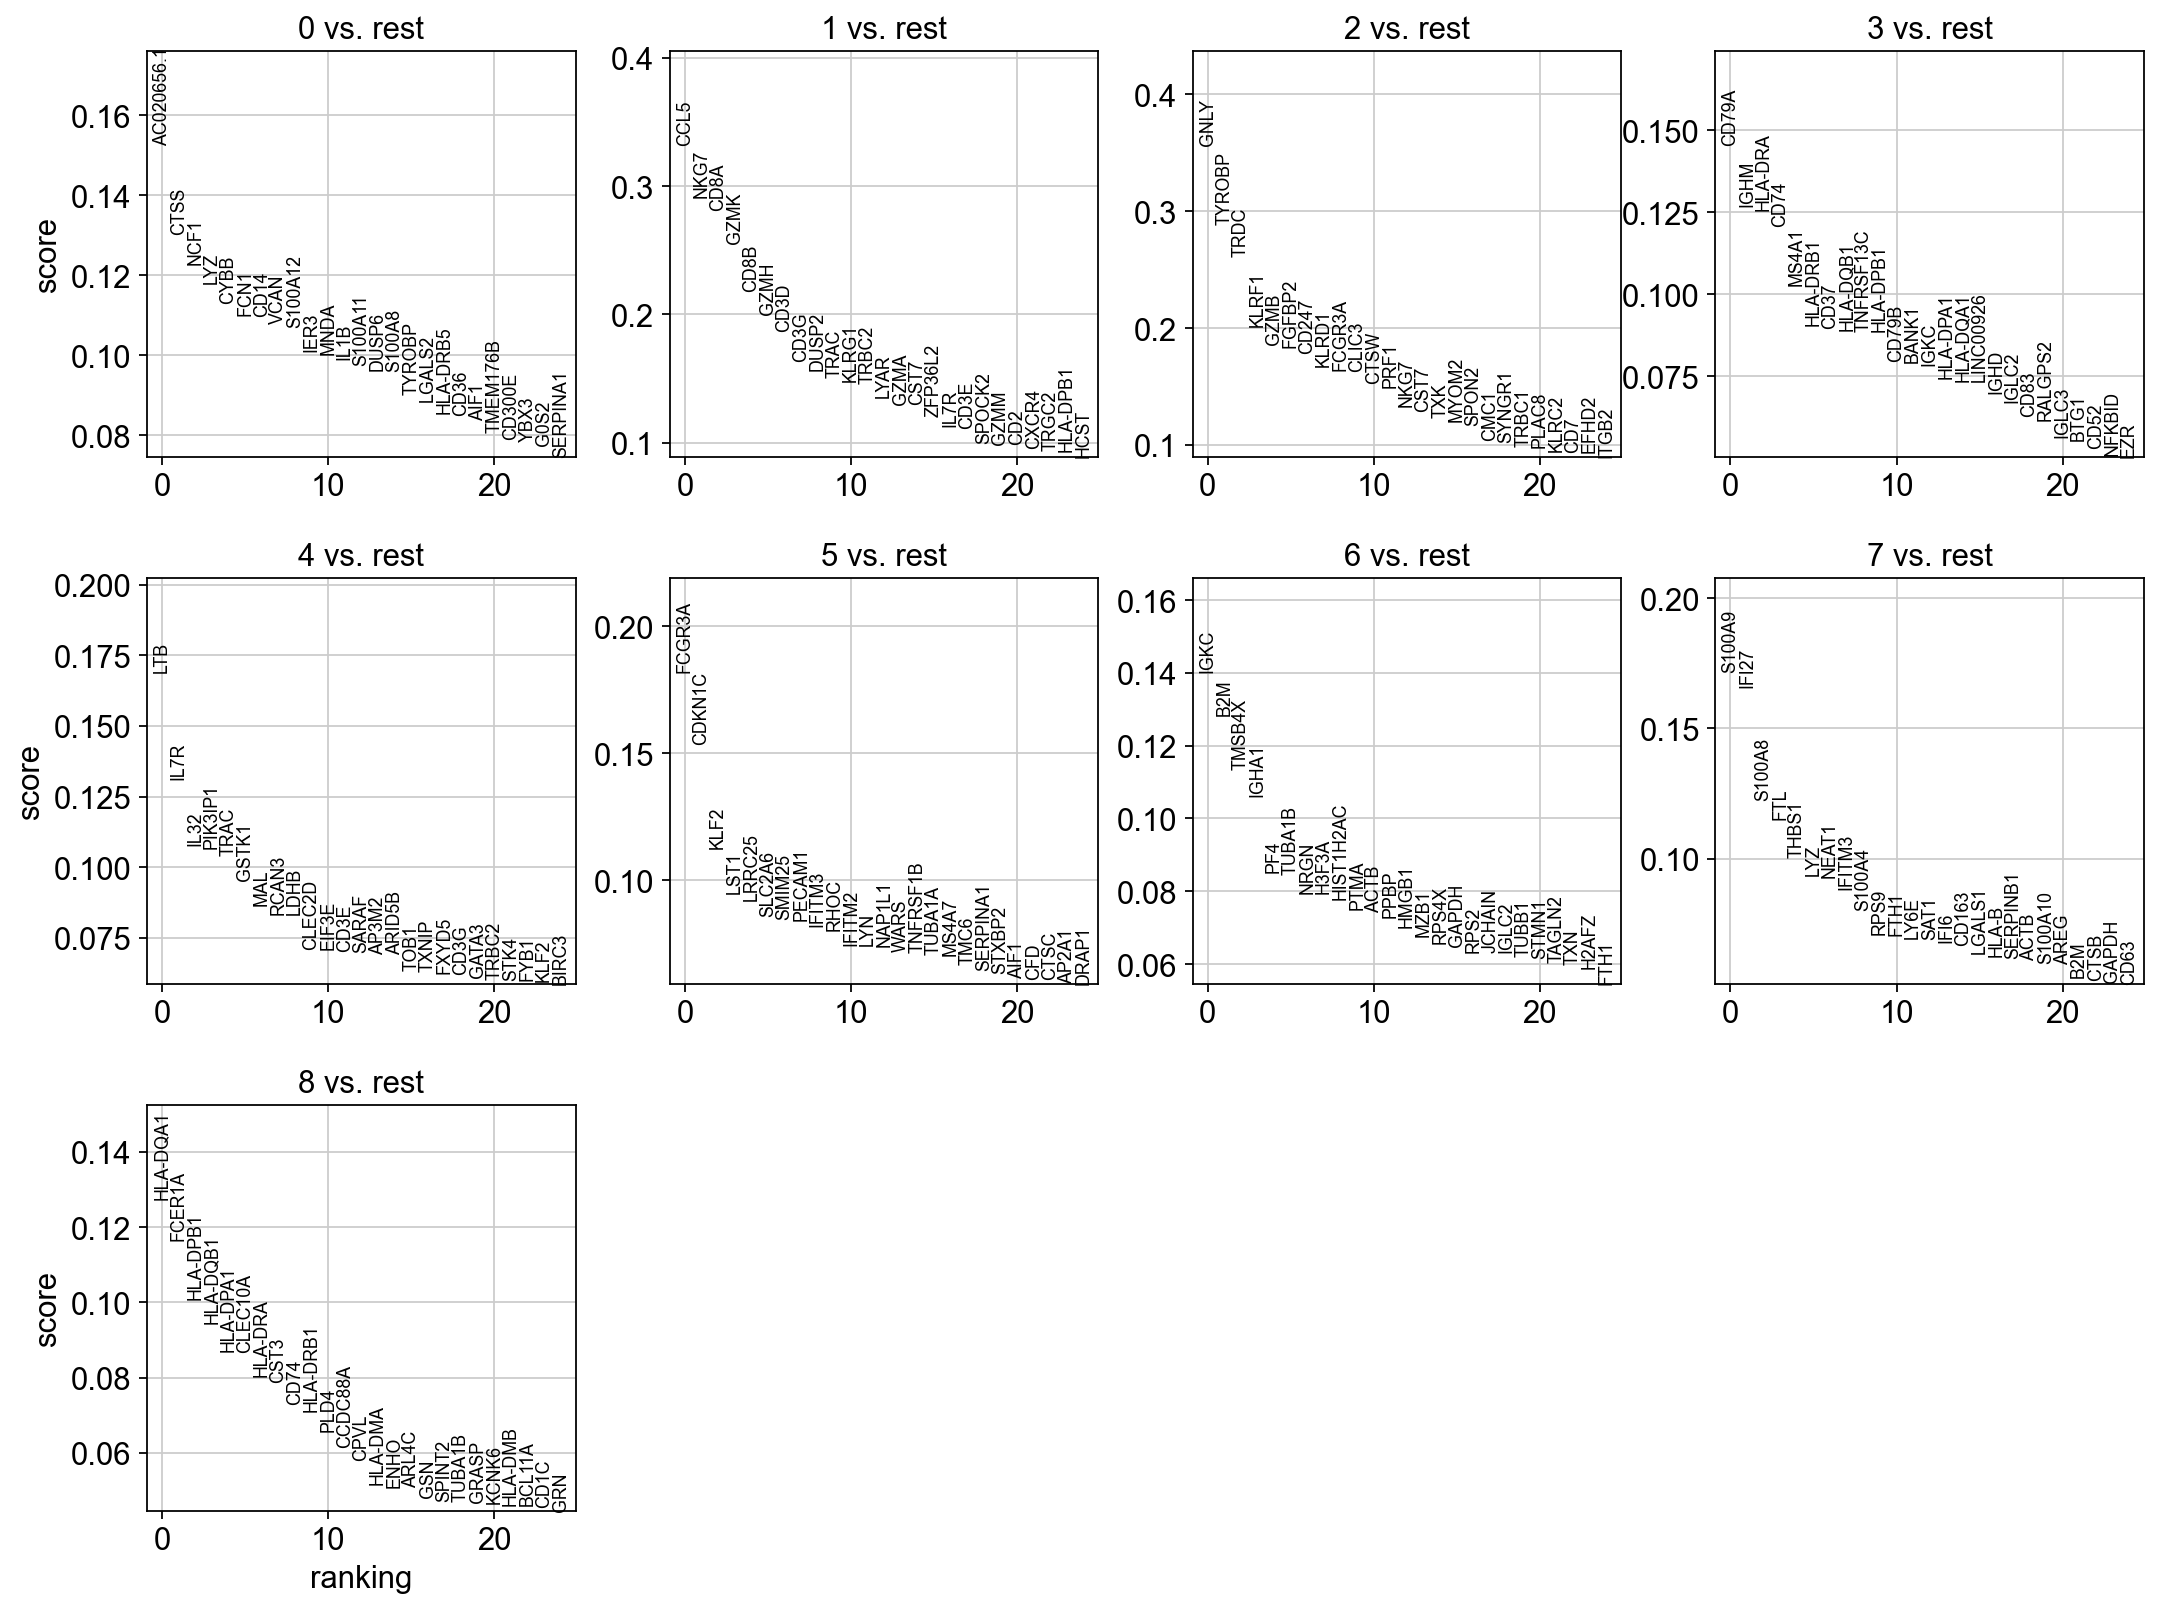

In [11]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### Compare genes

Take all significant DE genes for cluster0 with each test and compare the overlap.

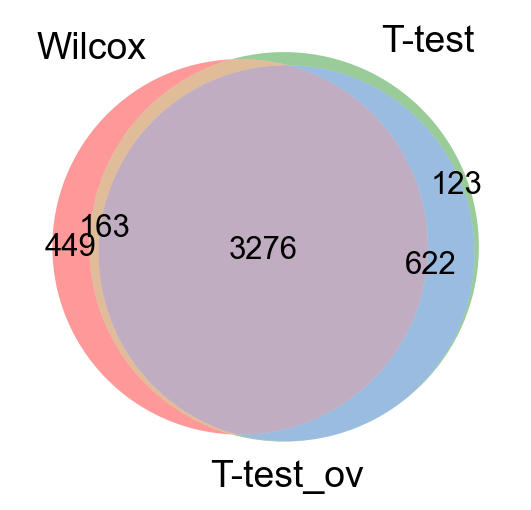

In [12]:
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()



As you can see, the Wilcoxon test and the T-test with overestimated variance gives very similar result. Also the regular T-test has good overlap, while the Logistic regression gives quite different genes.

### Visualization

There are several ways to visualize the expression of top DE genes. Here we will plot top 5 genes per cluster from Wilcoxon test as heatmap, dotplot, violin plot or matrix.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


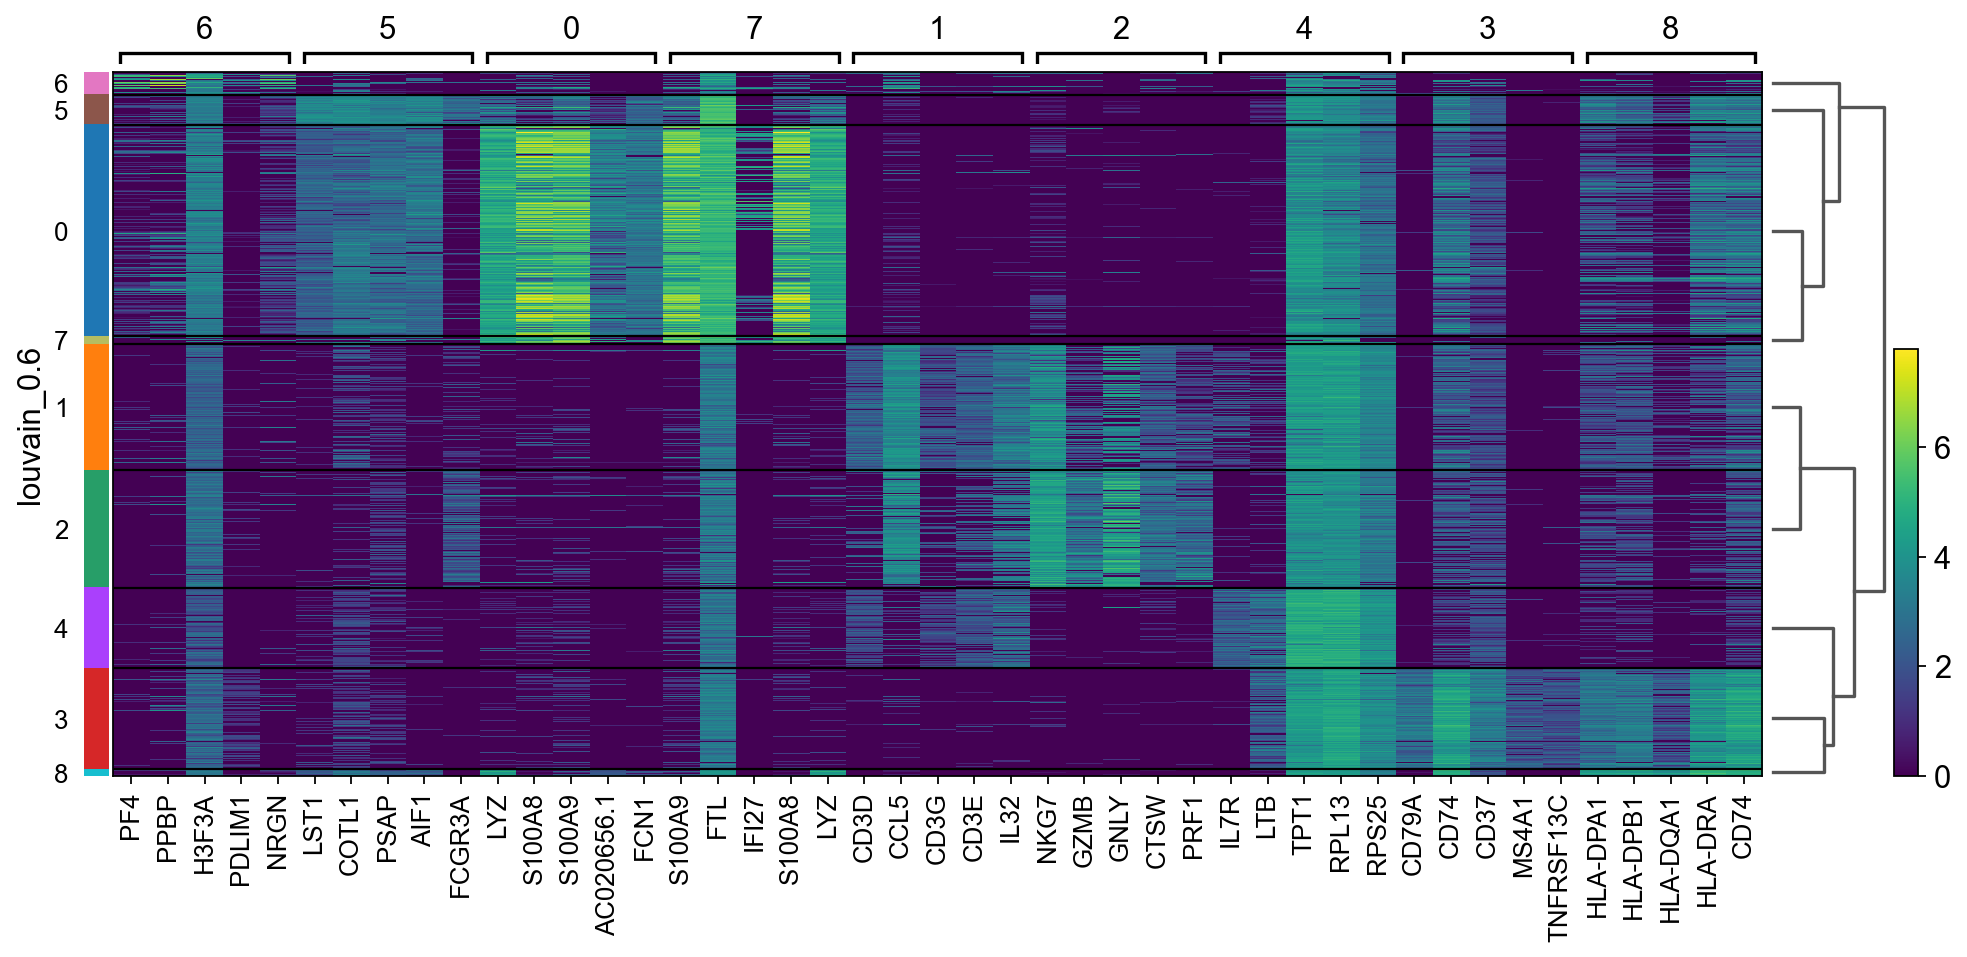

In [13]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6", show_gene_labels=True)

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


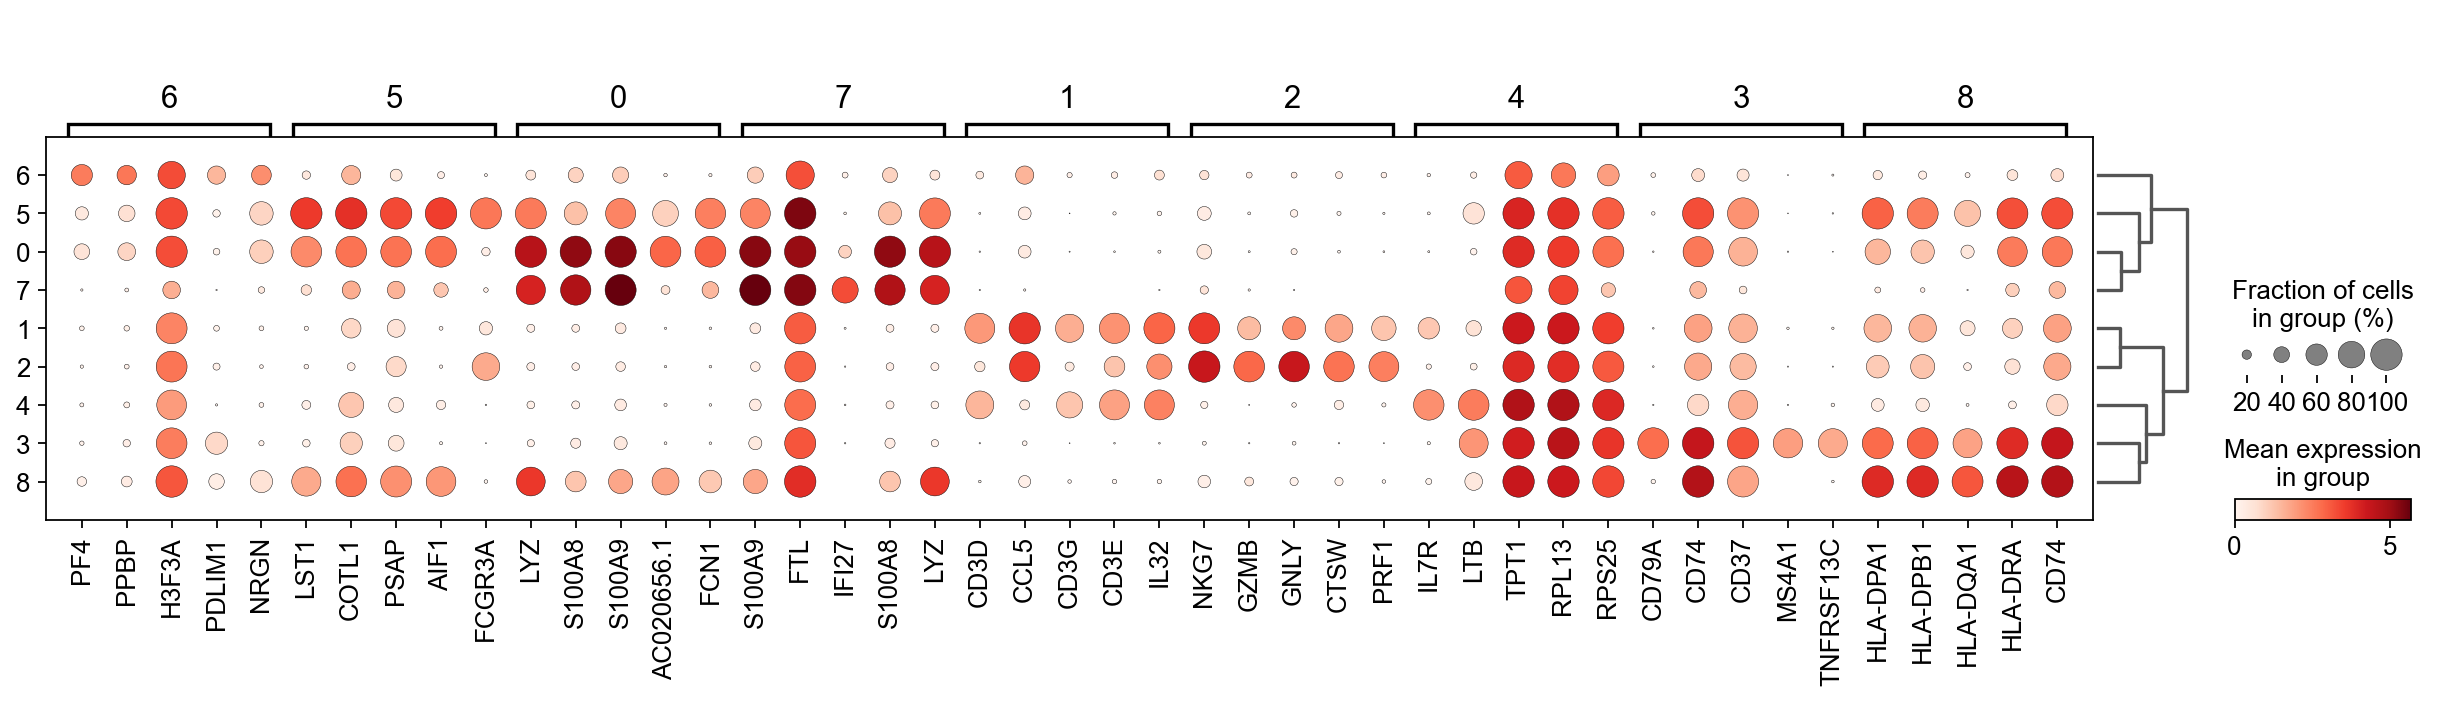

In [14]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

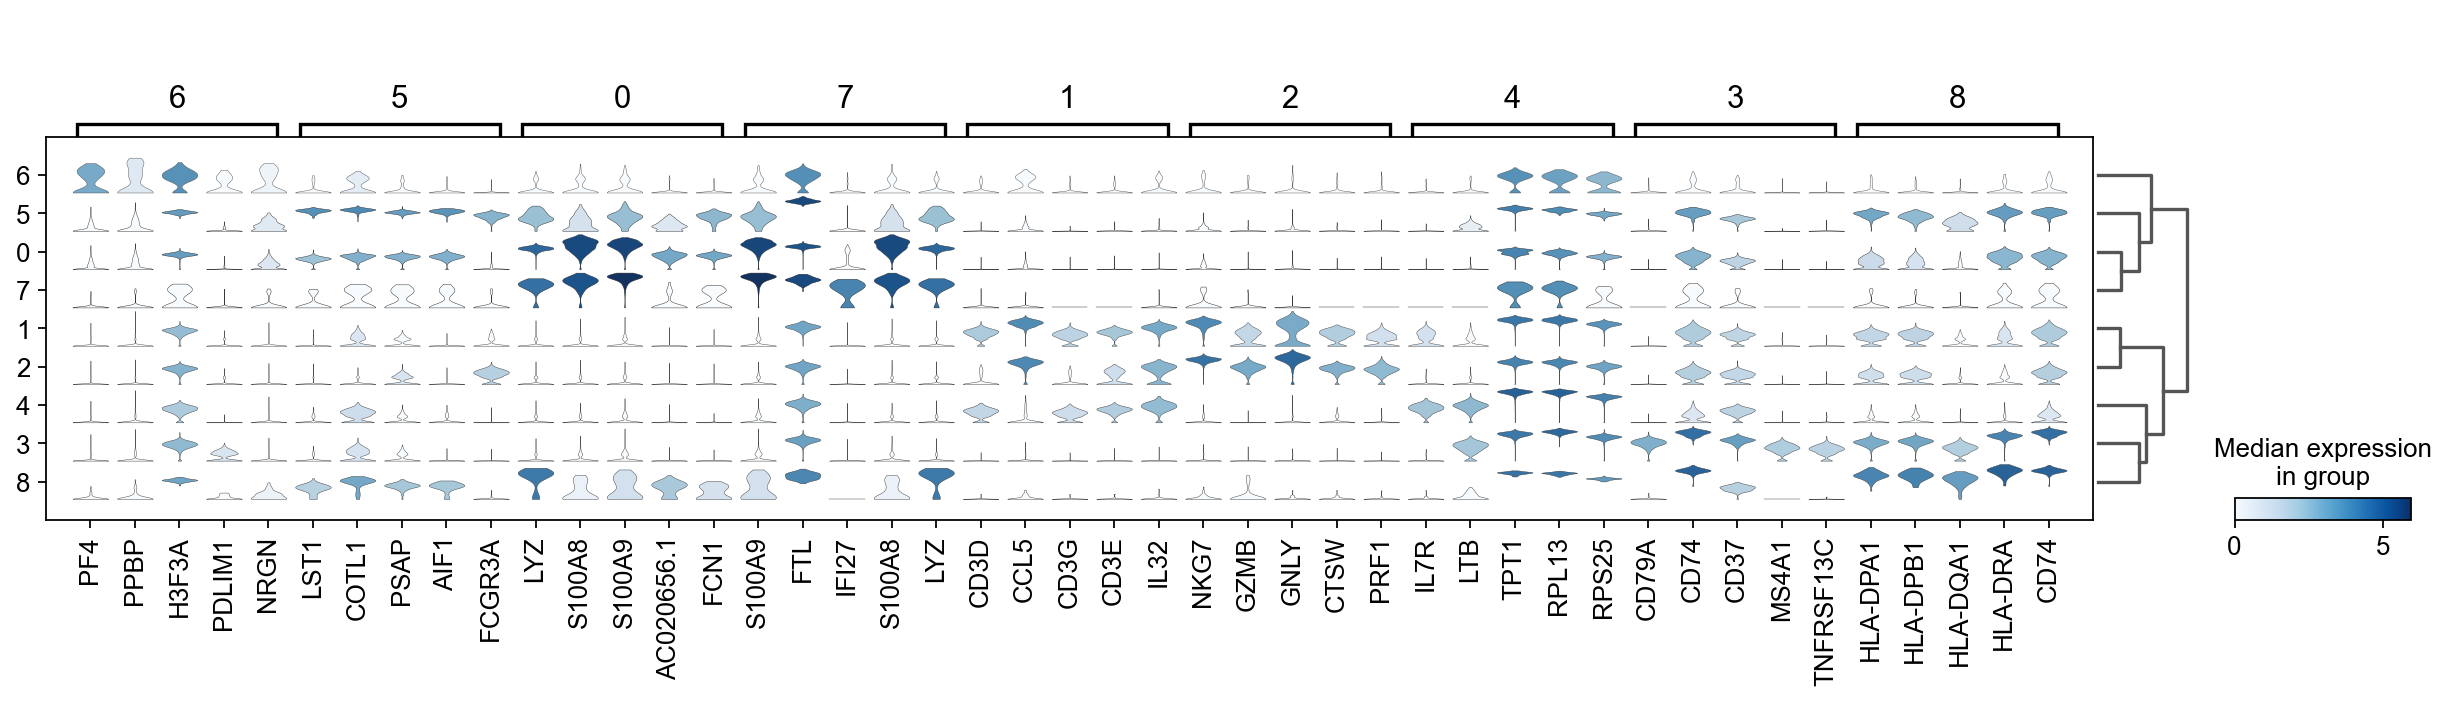

In [15]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

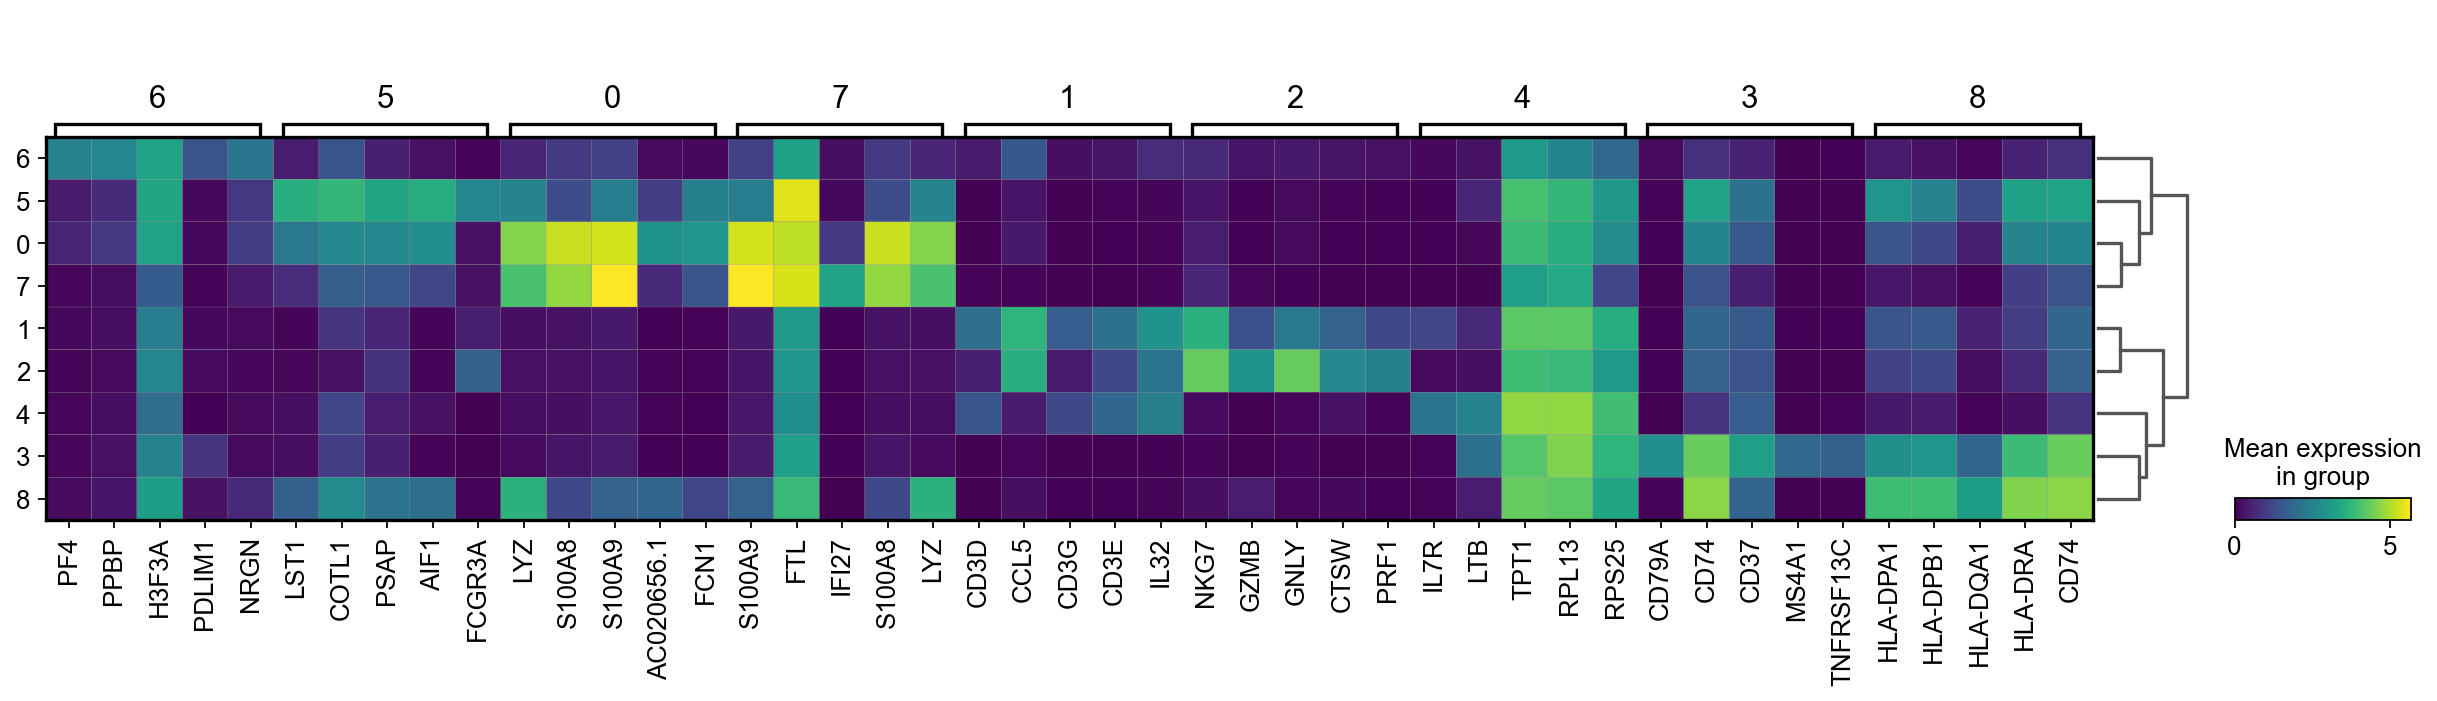

In [16]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

### Compare specific clusters

We can also do pairwise comparisons of individual clusters on one vs many clusters. 

For instance, clusters 1 & 2 have very similar expression profiles.

ranking genes
    finished (0:00:01)


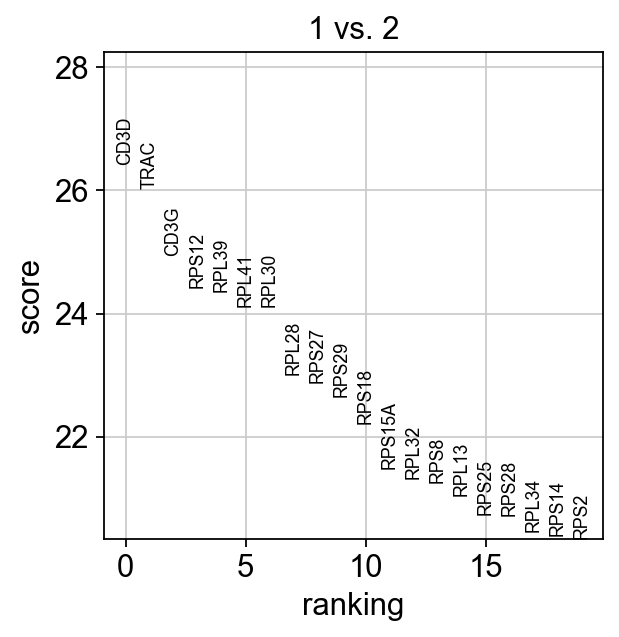

In [17]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

Plot as violins for those two groups.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


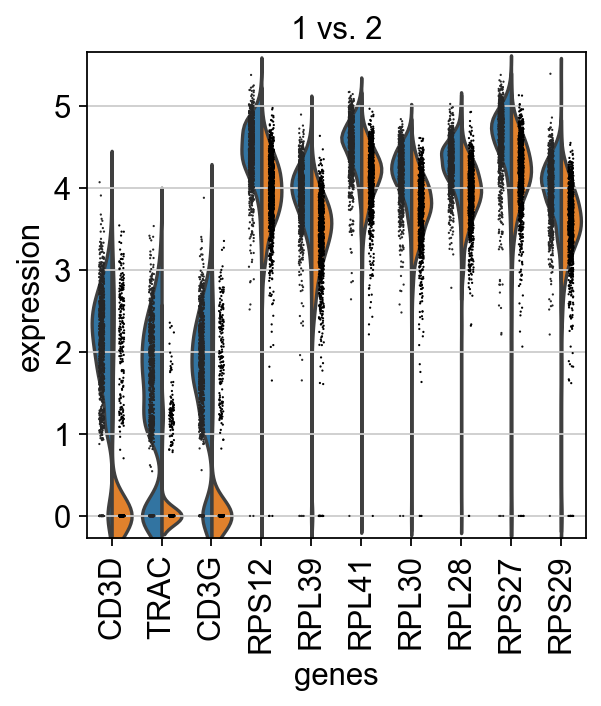

In [18]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)


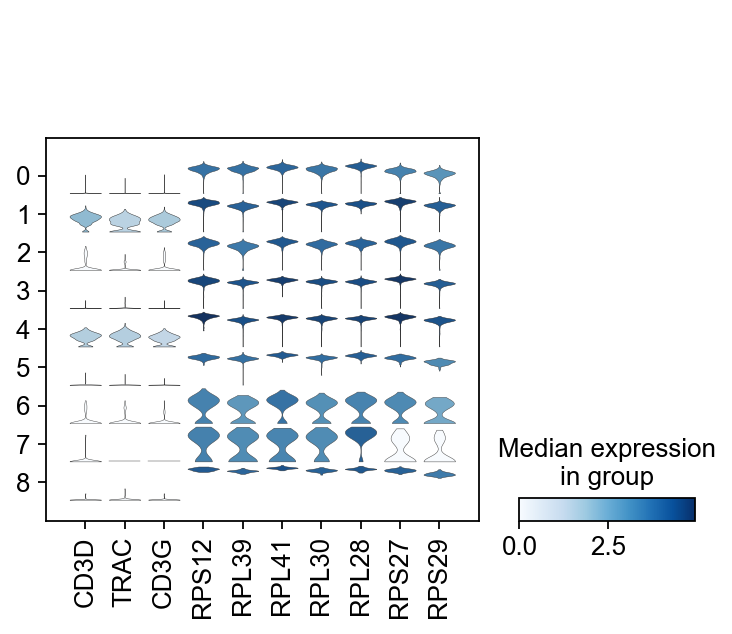

In [19]:
# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'louvain_0.6')



## Differential expression across conditions
***

The second way of computing differential expression is to answer which genes are differentially expressed within a cluster. For example, in our case we have libraries comming from patients and controls and we would like to know which genes are influenced the most in a particular cell type.

For this end, we will first subset our data for the desired cell cluster, then change the cell identities to the variable of comparison (which now in our case is the "type", e.g. Covid/Ctrl).


In [20]:
cl1 = adata[adata.obs['louvain_0.6'] == '3',:]
cl1.obs['type'].value_counts()

Covid    441
Ctrl     363
Name: type, dtype: int64

ranking genes


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:00)


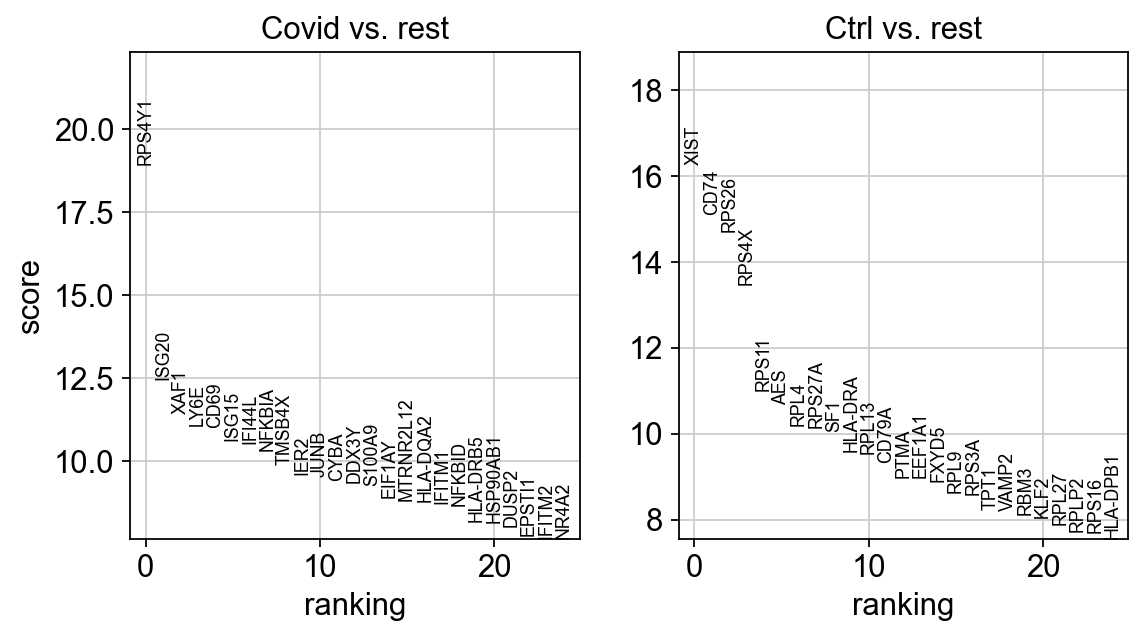

In [21]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


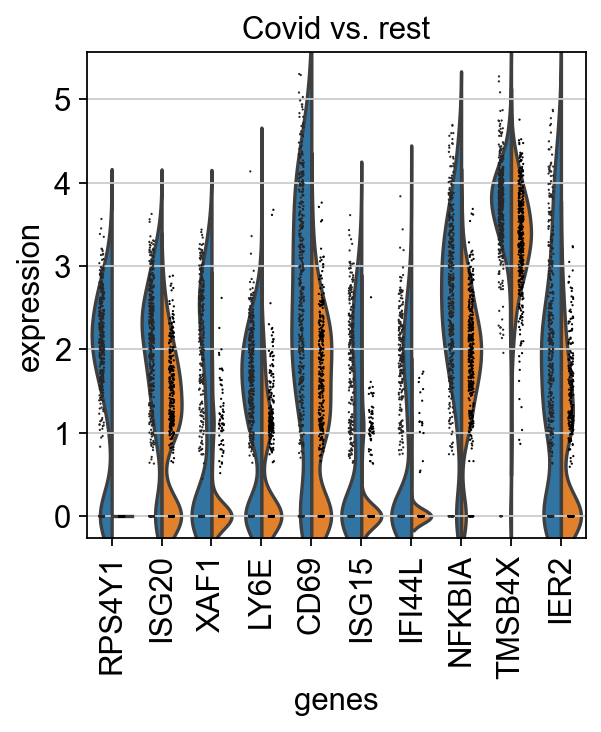

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


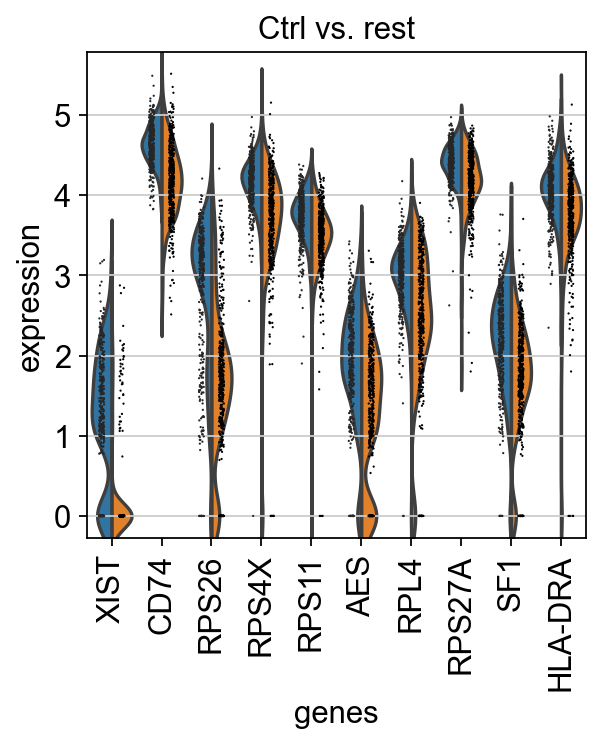

In [22]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")


We can also plot these genes across all clusters, but split by "type", to check if the genes are also up/downregulated in other celltypes.


In [23]:
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['louvain_0.6','type'], use_raw=False)
df2 = df.melt(id_vars=["louvain_0.6",'type'], value_vars=genes)



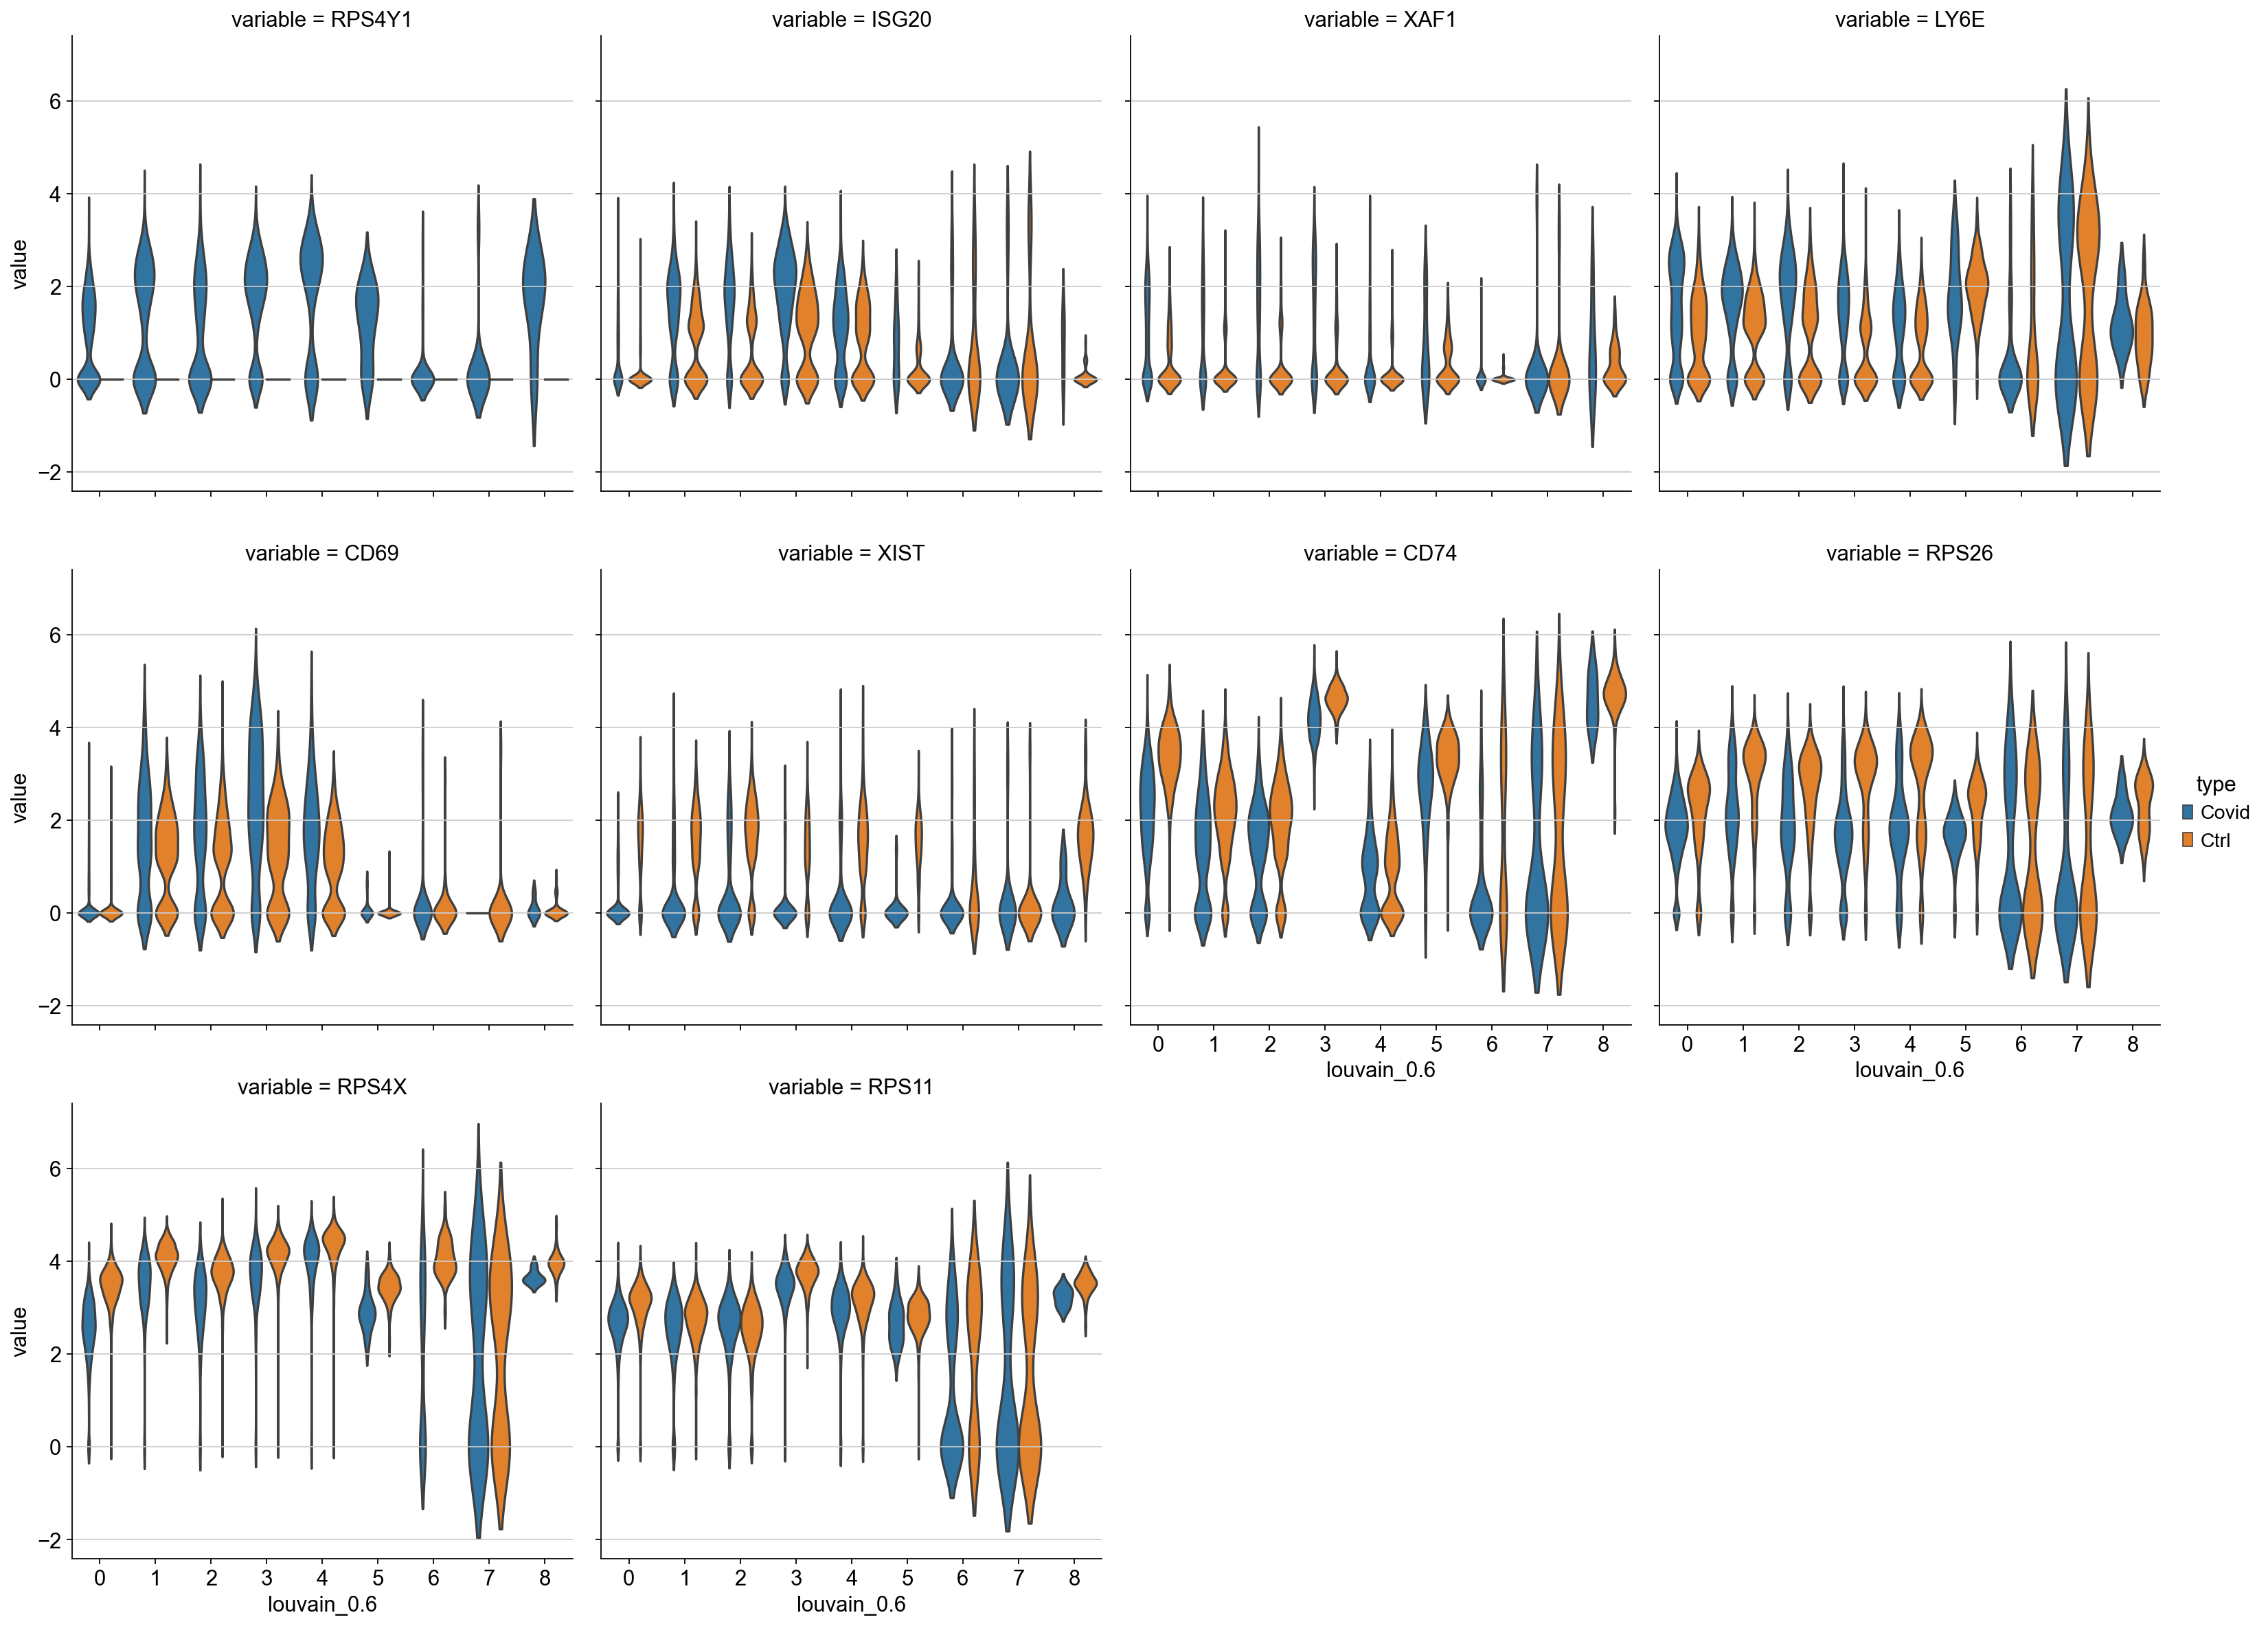

In [24]:
sns.catplot(x = "louvain_0.6", y = "value", hue = "type", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)

As you can see, we hwve many sex chromosome related genes among the top DE genes. And if you remember from the QC lab, we have inbalanced sex distribution among our subjects, so this may not be related to covid at all. 

### Remove sex chromosome genes

To remove some of the bias due to inbalanced sex in the subjects we can remove the sex chromosome related genes.

In [25]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrX_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "X"])



In [26]:
sex_genes = chrY_genes.union(chrX_genes)
print(len(sex_genes))
all_genes = cl1.var.index.tolist()
print(len(all_genes))

keep_genes = [x for x in all_genes if x not in sex_genes]
print(len(keep_genes))

cl1 = cl1[:,keep_genes]

537
18752
18215


Rerun differential expression.

ranking genes


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:00)


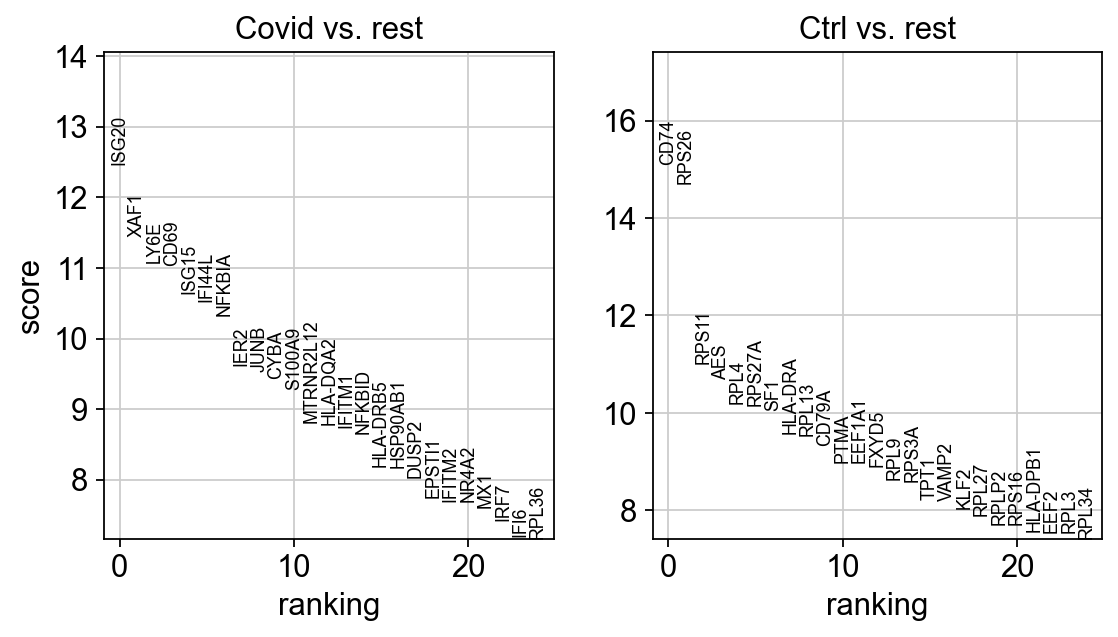

In [27]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

## Patient Batch effects

When we are testing for Covid vs Control we are running a DGE test for 3 vs 3 individuals. That will be very sensitive to sample differences unless we find a way to control for it. So first, lets check how the top DGEs are expressed across the individuals:

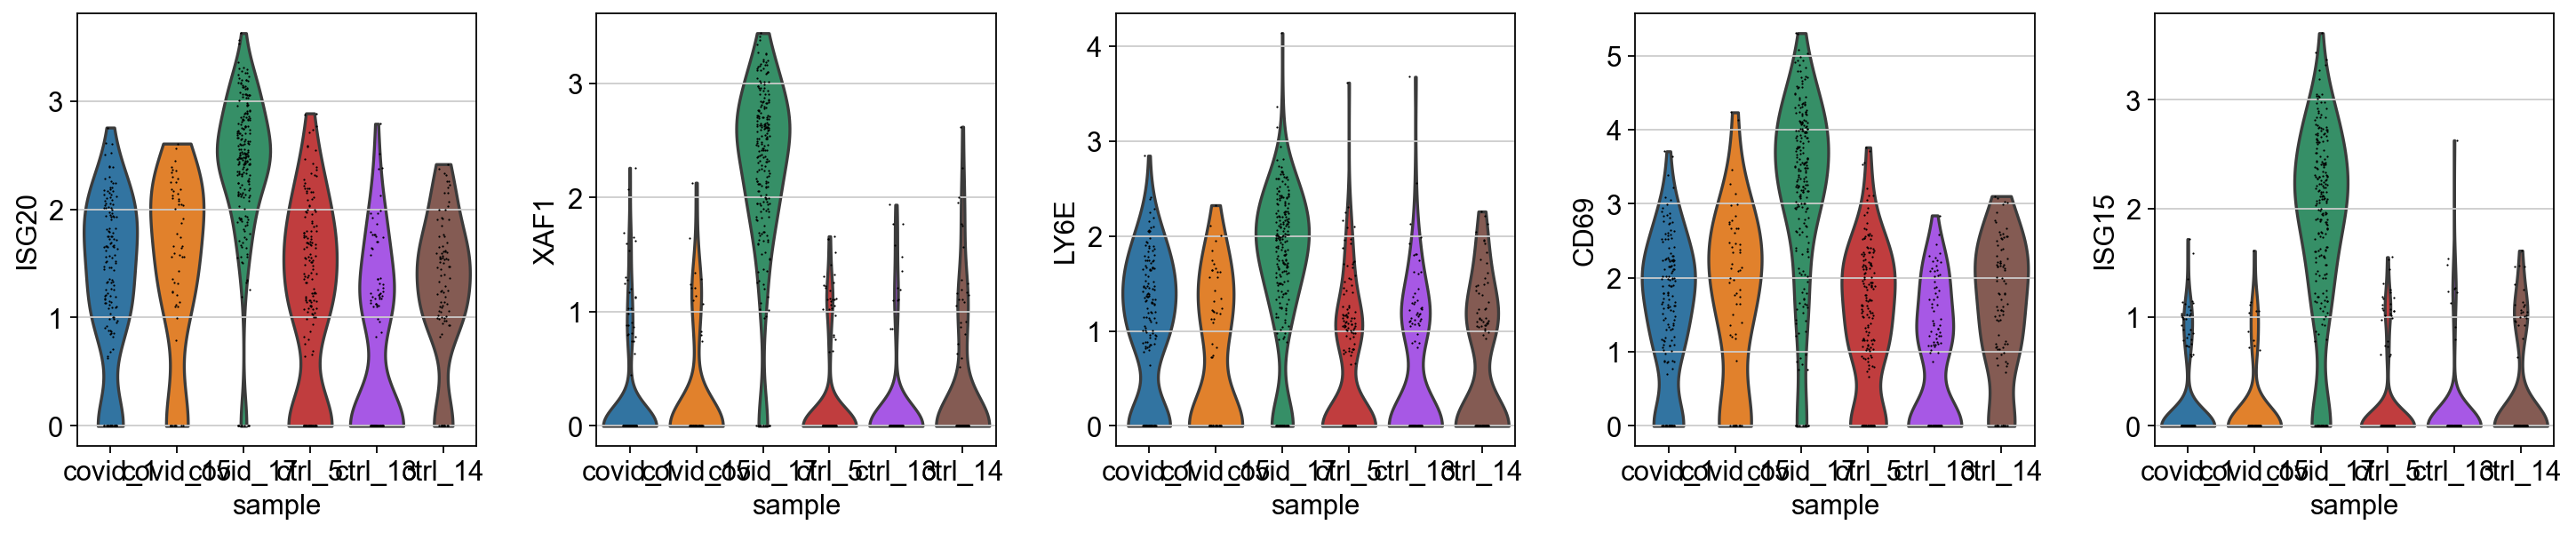

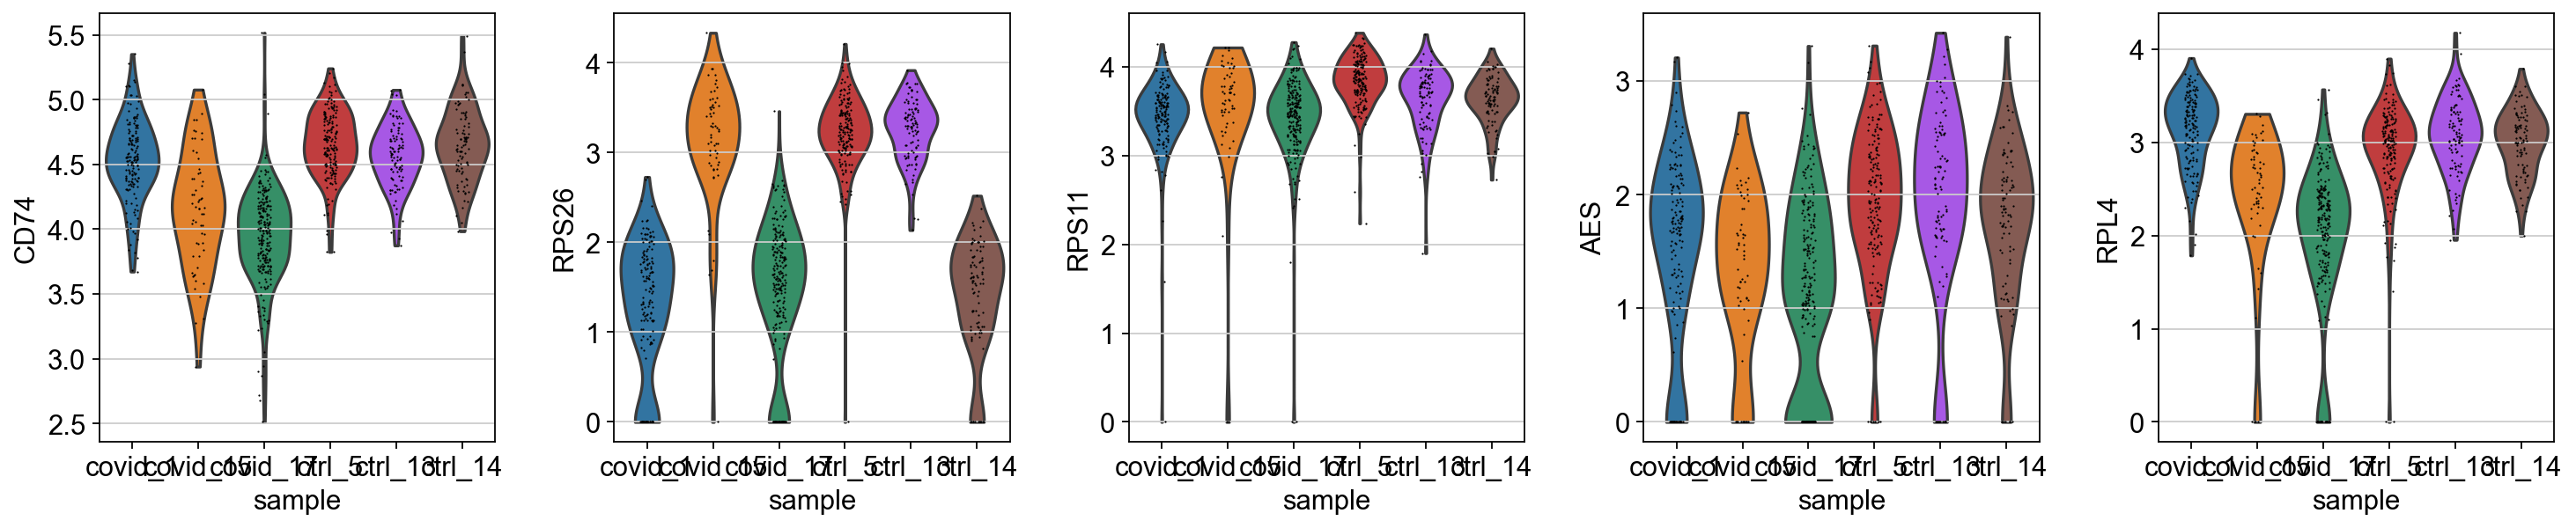

In [28]:
genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.violin(cl1, genes1, groupby='sample')
sc.pl.violin(cl1, genes2, groupby='sample')

As you can see, many of the genes detected as DGE in Covid are unique to one or 2 patients.

We can examine more genes with a DotPlot:

We can also plot the top Covid and top Ctrl genes as a dotplot:

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


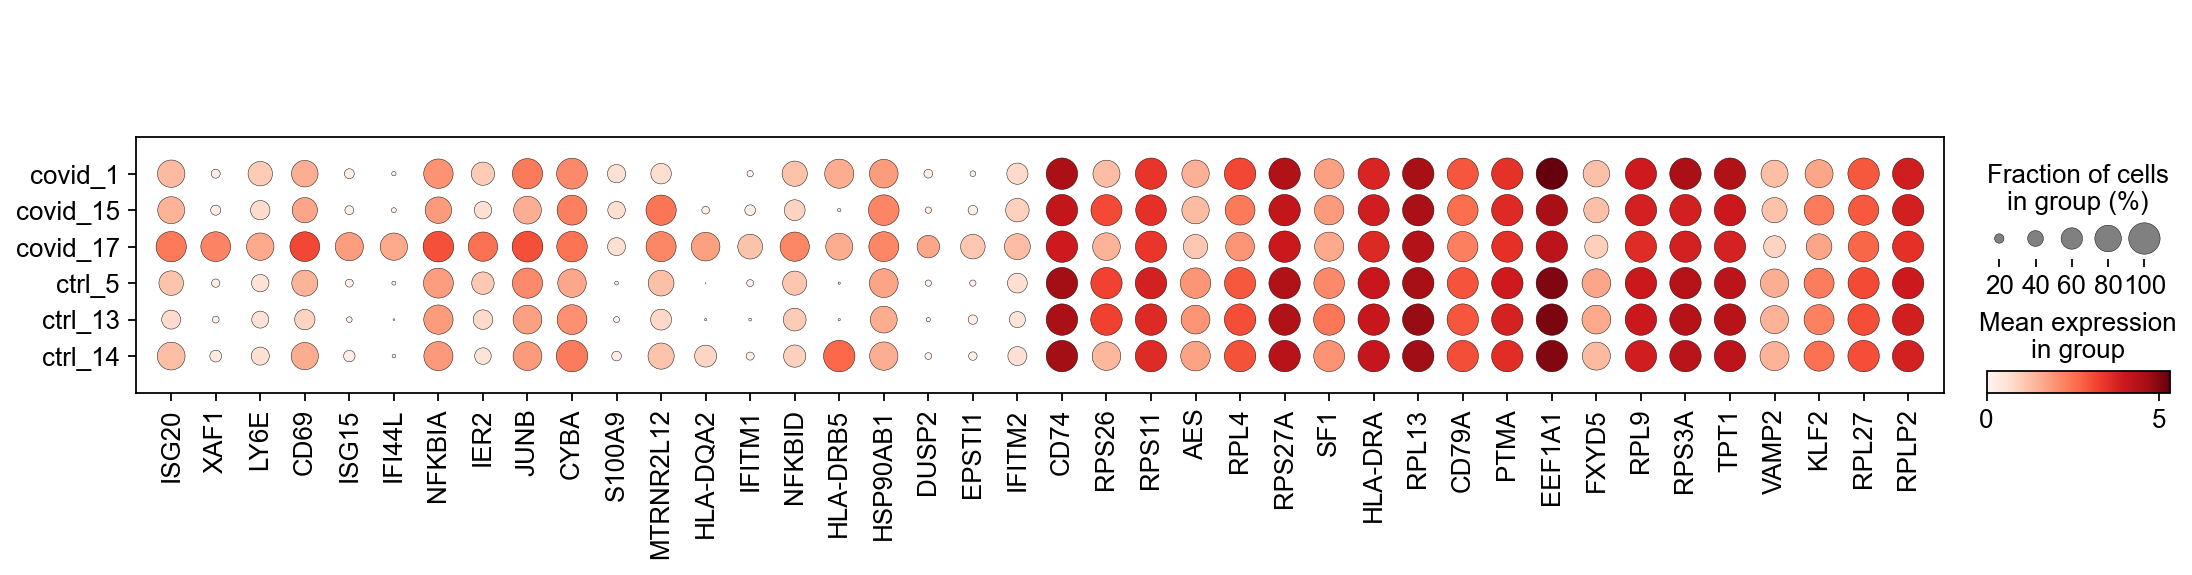

In [29]:
genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:20]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(cl1,genes, groupby='sample')

Clearly many of the top Covid genes are only high in the `covid_17` sample, and not a general feature of covid patients. 

This is also the patient with the highest number of cells in this cluster:



In [30]:
cl1.obs['sample'].value_counts()

covid_17    228
ctrl_5      171
covid_1     154
ctrl_13     100
ctrl_14      92
covid_15     59
Name: sample, dtype: int64

## Subsample

So one obvious thing to consider is an equal amount of cells per individual so that the DGE results are not dominated by a single sample.

So we will downsample to an equal number of cells per sample.


In [31]:
cl1.obs['sample'].value_counts()

covid_17    228
ctrl_5      171
covid_1     154
ctrl_13     100
ctrl_14      92
covid_15     59
Name: sample, dtype: int64

In [32]:
target_cells = 50

tmp = [cl1[cl1.obs['sample'] == s] for s in cl1.obs['sample'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

cl1_sub = tmp[0].concatenate(*tmp[1:])

cl1_sub.obs['sample'].value_counts()

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype be

covid_1     50
covid_15    50
covid_17    50
ctrl_5      50
ctrl_13     50
ctrl_14     50
Name: sample, dtype: int64

ranking genes
    finished (0:00:00)


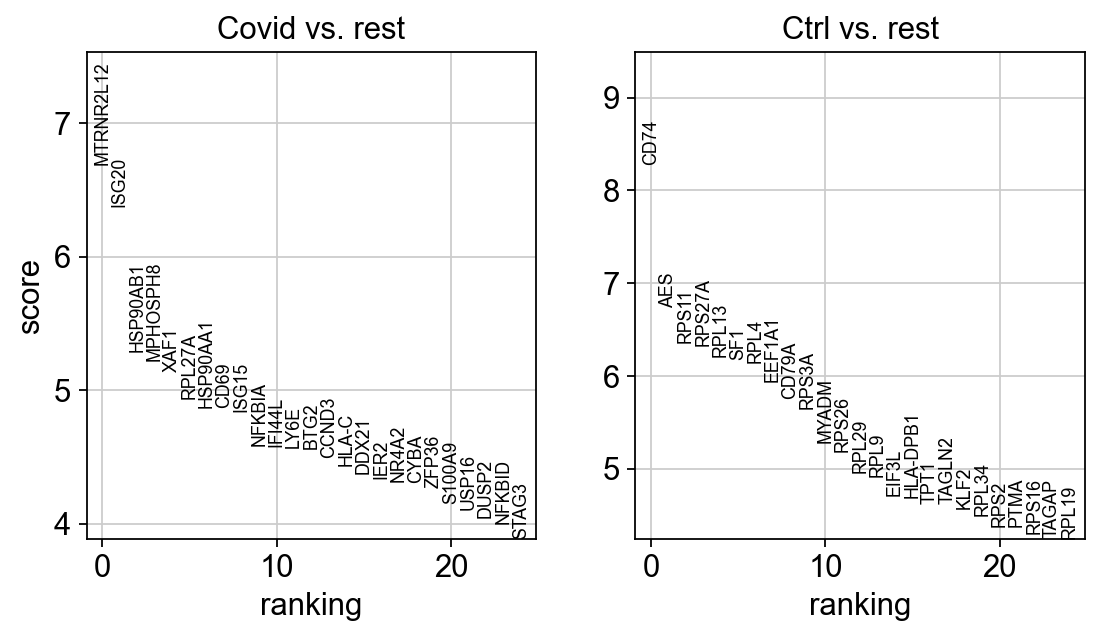

In [33]:
sc.tl.rank_genes_groups(cl1_sub, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1_sub, n_genes=25, sharey=False, key="wilcoxon")

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


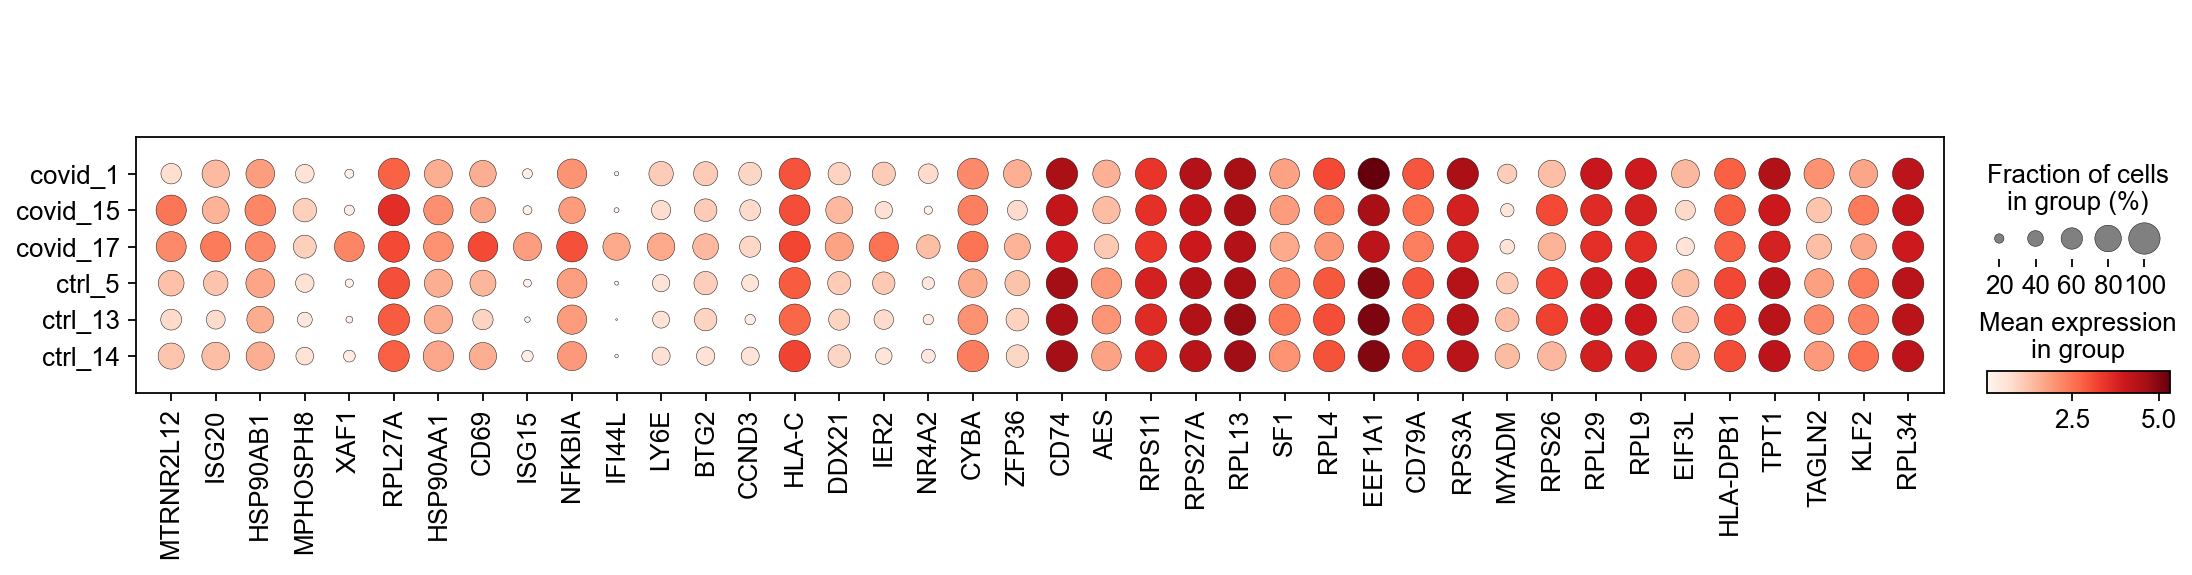

In [34]:
genes1 = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', key='wilcoxon')['names'][:20]
genes2 = sc.get.rank_genes_groups_df(cl1_sub, group='Ctrl', key='wilcoxon')['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(cl1,genes, groupby='sample')

It looks much better now. But if we look per patient you can see that we still have some genes that are dominated by a single patient. Still, it is often a good idea to control the number of cells from each sample when doing differential expression. 


Why do you think this is?



There are many different ways to try and resolve the issue of patient batch effects, however most of them require R packages. These can be run via `rpy2` as is demonstraded in this compendium: https://www.sc-best-practices.org/conditions/differential_gene_expression.html#

However, we have not included it here as of now. So please have a look at the patient batch effect section in the seurat DGE tutorial where we run EdgeR on pseudobulk and MAST with random effect. 

## Gene Set Analysis
***

Hypergeometric enrichment test

Having a defined list of differentially expressed genes, you can now look for their combined function using hypergeometric test:


In [35]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

Get the significant DEGs for the Covid patients.

In [36]:
#?gseapy.enrichr
glist = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

31


In [37]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     cutoff = 0.5)

In [38]:
enr_res.results.head()

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  cellular response to type I interferon (GO:007...    7/65  6.786724e-12   
1   type I interferon signaling pathway (GO:0060337)    7/65  6.786724e-12   
2   cytokine-mediated signaling pathway (GO:0019221)   9/633  3.252874e-07   
3  negative regulation of viral genome replicatio...    4/50  1.034460e-06   
4  negative regulation of viral life cycle (GO:19...    4/61  2.316389e-06   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.353951e-09            0                     0  100.127155   
1      1.353951e-09            0                     0  100.127155   
2      4.326322e-05            0                     0   12.682474   
3      1.031873e-04            0                     0   64.164251   
4      1.754477e-04            0                     0   51.753086   

   Combined Score                                              Genes  
0     2574.875209            ISG20;IFITM1;MX1;HLA-C;ISG15;HLA-A;XAF1  
1     2574.875209            ISG20;IFITM1;MX1;HLA-C;ISG15;HLA-A;XAF1  
2      189.457854  ISG20;NFKBIA;HSP90AA1;IFITM1;MX1;HLA-C;ISG15;H...  
3      884.288064                             ISG20;IFITM1;MX1;ISG15  
4      671.522216                             ISG20;IFITM1;MX1;ISG15


Some databases of interest:

* `GO_Biological_Process_2017b`
* `KEGG_2019_Human`
* `KEGG_2019_Mouse`
* `WikiPathways_2019_Human`
* `WikiPathways_2019_Mouse`

You visualize your results using a simple barplot, for example:


<AxesSubplot: title={'center': 'GO_Biological_Process_2018'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

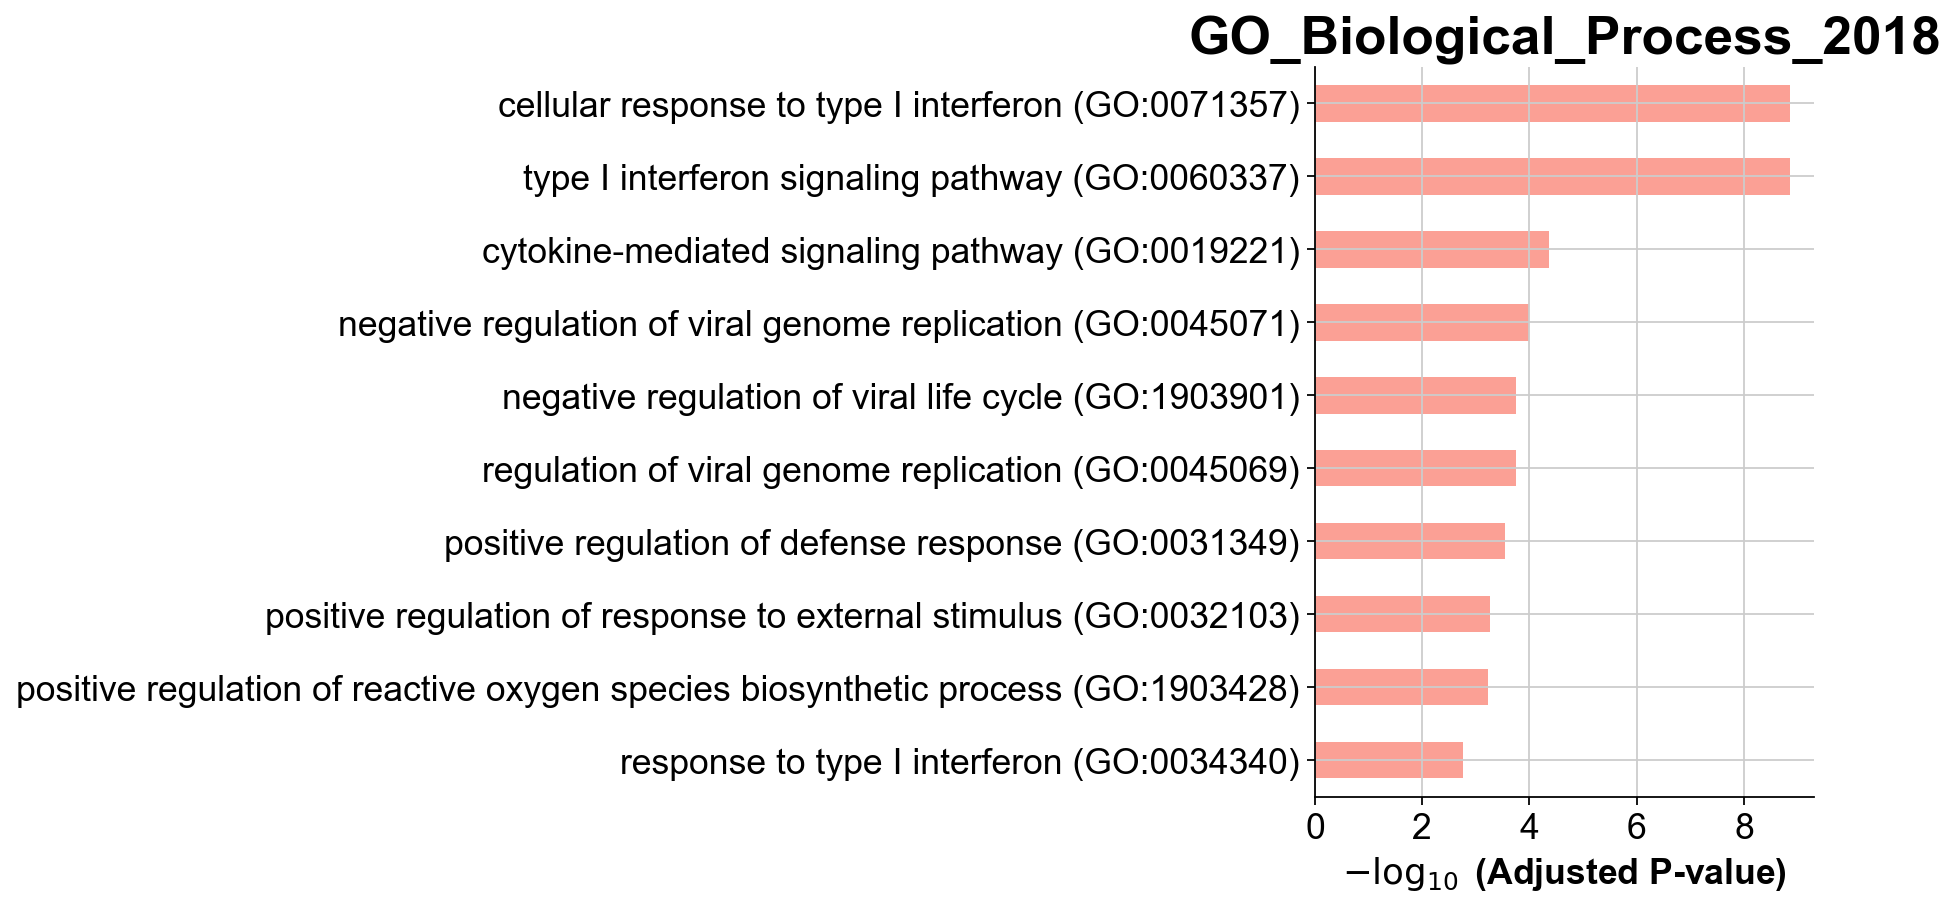

In [39]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

## Gene Set Enrichment Analysis (GSEA)

Besides the enrichment using hypergeometric test, we can also perform gene set enrichment analysis (GSEA), which scores ranked genes list (usually based on fold changes) and computes permutation test to check if a particular gene set is more present in the Up-regulated genes, amongthe DOWN_regulated genes or not differentially regulated.


We need a table with all DEGs and their log foldchanges. However, many lowly expressed genes will have high foldchanges and just contribue noise, so also filter for expression in enough cells. 

In [40]:
gene_rank = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [41]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(cl1, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(cl1.var_names[cl1.var.n_cells_by_counts>30])]


In [42]:
gene_rank

names  logfoldchanges
333       TTTY15       26.927898
500        CXCL8       26.704372
588       ZNF703       26.562613
827         IER3       26.463541
972         LCN8       26.268150
...          ...             ...
16883  LINC00115       -3.203356
17947    FAM111B       -3.355543
17095    SLC6A16       -3.542606
16636      CNNM3       -3.731907
16300    ANKRD46      -25.070192

[7836 rows x 2 columns]

 Once our list of genes are sorted, we can proceed with the enrichment itself. We can use the package to get gene set from the Molecular Signature Database (MSigDB) and select KEGG pathways as an example.


In [43]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

 Next, we will be using the GSEA. This will result in a table containing information for several pathways. We can then sort and filter those pathways to visualize only the top ones. You can select/filter them by either `p-value` or normalized enrichemnet score (`NES`).


In [44]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

In [45]:
terms = res.res2d.Term
terms[:10]

0    Viral protein interaction with cytokine and cy...
1                                 Rheumatoid arthritis
2                 Toll-like receptor signaling pathway
3               Cytokine-cytokine receptor interaction
4                                       Bladder cancer
5                                       Chagas disease
6                          Chemokine signaling pathway
7                                          Hepatitis C
8                         NF-kappa B signaling pathway
9                            Lipid and atherosclerosis
Name: Term, dtype: object

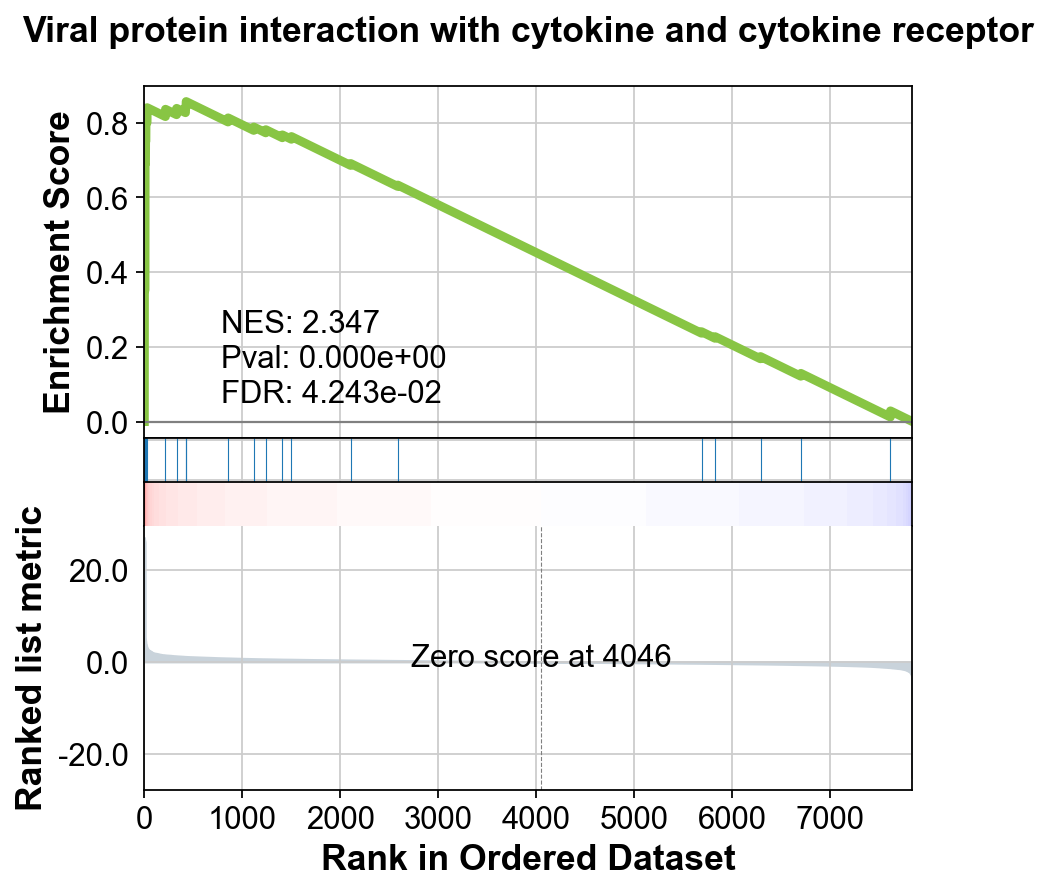

In [46]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

<style>
div.blue { background-color:#e6f0ff; border-radius: 5px; padding: 10px;}
</style>
<div class = "blue">
**Your turn**

Which KEGG pathways are upregulated in this cluster?
Which KEGG pathways are dowregulated in this cluster?
Change the pathway source to another gene set (e.g. "CP:WIKIPATHWAYS" or "CP:REACTOME" or "CP:BIOCARTA" or "GO:BP") and check the if you get simmilar results?
</div>

Finally, lets save the integrated data for further analysis.


In [47]:
adata.write_h5ad('./data/results/scanpy_DGE_covid.h5ad')